In [2]:
# Import niezbędnych bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from itertools import product
from prettytable import PrettyTable
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Lista hiperparametrów do eksperymentów
hidden_size_list = [32, 64]  # Liczba neuronów w warstwie ukrytej
num_layers_list = [1, 3]  # Liczba warstw RNN
dropout_list = [0.1, 0.2]  # Dropout
learning_rate_list = [0.001, 0.0001]  # Learning rate
sequence_lengths = [30, 100, 150]  # Długość szeregu czasowego używanego w procesie nauki

# Kombinacje wszystkich hiperparametrów
param_combinations = list(product(sequence_lengths, hidden_size_list, num_layers_list, dropout_list, learning_rate_list))

In [5]:
# Wczytanie danych z pliku CSV
data = pd.read_excel('Open-Open-Dataset-BTC.xlsx')

data.head()
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4921 entries, 0 to 4920
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4921 non-null   datetime64[ns]
 1   LogReturn         4921 non-null   float64       
 2   Open              4921 non-null   float64       
 3   High              4921 non-null   float64       
 4   Low               4921 non-null   float64       
 5   Close             4921 non-null   float64       
 6   Volume            4921 non-null   float64       
 7   MarketCap         4921 non-null   float64       
 8   FearAndGreed      4921 non-null   int64         
 9   VDD               4921 non-null   float64       
 10  CBBI              4921 non-null   float64       
 11  GoldClose         4921 non-null   float64       
 12  DaysSinceHalving  4921 non-null   int64         
 13  S&P500            4921 non-null   float64       
 14  M2SL              4921 n

In [6]:
# Funkcja czyszcząca dane - usuwa niepotrzebne znaki
def clean_and_convert_to_numeric(df):
    return df.applymap(
        lambda x: float(str(x).replace(',', '.').replace('\xa0', '').strip())
        if isinstance(x, str) else x
    )

# Czyszczenie danych i usunięcie zbędnych kolumn
data_cleaned = clean_and_convert_to_numeric(data.drop(columns=['Date', 'Close'], errors='ignore'))

# Podział na cechy (X) i cel (y)
X = data_cleaned.drop(columns=['LogReturn'], errors='ignore').values
y = data_cleaned['LogReturn'].values

# Skalowanie danych wejściowych i celu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Podział danych na zbiory treningowy, walidacyjny i testowy
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<ipython-input-6-1a1ea2ec797e>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [7]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())

# Wyświetlenie statystyk wartości docelowej
print(f"Min: {y.min()}, Max: {y.max()}, Mean: {y.mean()}")

0 0
0 0
Min: -0.45559, Max: 0.38797, Mean: 0.0017875553749237961


In [8]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4921 entries, 0 to 4920
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LogReturn         4921 non-null   float64
 1   Open              4921 non-null   float64
 2   High              4921 non-null   float64
 3   Low               4921 non-null   float64
 4   Volume            4921 non-null   float64
 5   MarketCap         4921 non-null   float64
 6   FearAndGreed      4921 non-null   int64  
 7   VDD               4921 non-null   float64
 8   CBBI              4921 non-null   float64
 9   GoldClose         4921 non-null   float64
 10  DaysSinceHalving  4921 non-null   int64  
 11  S&P500            4921 non-null   float64
 12  M2SL              4921 non-null   float64
 13  InflationUSA      4921 non-null   float64
 14  DXY               4921 non-null   float64
 15  VIX of VIX        4921 non-null   float64
 16  HashRate          4921 non-null   float64


In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        """
        Inicjalizacja zbioru danych. Tworzy sekwencje wejściowe i odpowiadające im wartości docelowe.
        """
        self.X, self.y = self.create_sequences(X, y, sequence_length)

    def create_sequences(self, X, y, sequence_length):
        """
        Tworzy sekwencje czasowe o określonej długości.
        """
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length):
            X_seq.append(X[i:i + sequence_length])  # Okno czasowe wejściowe
            y_seq.append(y[i + sequence_length])  # Docelowa wartość dla okna
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

    def __len__(self):
        """
        Zwraca liczbę próbek w zbiorze danych.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Zwraca próbkę (X_seq, y_seq) o indeksie `idx`.
        """
        return self.X[idx], self.y[idx]

In [10]:
# Funkcja do inicjalizacji modelu z różnymi parametrami
def initialize_model(input_size, hidden_size, num_layers, dropout):
    return RNNModel(input_size, hidden_size, num_layers, output_size=1, dropout=dropout)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(RNNModel, self).__init__()
        # Warstwa RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, nonlinearity='tanh')
        # Warstwa w pełni połączona (do mapowania na wynik wyjściowy)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Przejście przez warstwę RNN
        out, _ = self.rnn(x)
        # Przejście przez warstwę w pełni połączoną (używamy tylko ostatniego kroku czasowego)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]

In [11]:
criterion = nn.HuberLoss(delta=0.1)

def train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5
):
    """
    Funkcja trenowania modelu z mechanizmem wczesnego zatrzymania i rejestracją strat.
    """
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []  # Lista strat treningowych
    val_losses = []    # Lista strat walidacyjnych

    for epoch in range(num_epochs):
        start_time = time.time()

        # Trening
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1, 1))  # Upewnienie się, że y_batch ma odpowiedni wymiar
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(-1, 1))  # Upewnienie się, że y_batch ma odpowiedni wymiar
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        end_time = time.time()
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Duration: {end_time - start_time:.2f}s")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Zapis najlepszego modelu
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # Wczytanie najlepszego modelu
    model.load_state_dict(torch.load('best_model.pth'))

    # Zwrócenie modelu i strat do wizualizacji
    return model, train_losses, val_losses

In [12]:
# Funkcja treningu z wczesnym zatrzymaniem i eksperymentami
def train_and_evaluate(param_combination):
    sequence_length, hidden_size, num_layers, dropout, learning_rate = param_combination

    # Tworzenie zbiorów danych i DataLoaderów dla danej długości sekwencji
    train_dataset = TimeSeriesDataset(X_train, y_train, sequence_length)
    val_dataset = TimeSeriesDataset(X_val, y_val, sequence_length)
    test_dataset = TimeSeriesDataset(X_test, y_test, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Inicjalizacja modelu (zamiana LSTMModel na RNNModel)
    model = RNNModel(input_size, hidden_size, num_layers, output_size=1, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Trenowanie modelu
    trained_model, train_losses, val_losses = train_model_with_early_stopping(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5
    )

    # Zwrócenie wyników
    return trained_model, train_losses, val_losses, val_losses[-1], test_loader  # Ostatnia strata walidacyjna

Testowanie kombinacji 1/48: (30, 32, 1, 0.1, 0.001)


<ipython-input-9-dfed0ad65618>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0113, Val Loss: 0.0019, Duration: 0.51s
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.28s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.27s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.27s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.28s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.28s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.28s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.27s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.29s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.28s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.28s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0019, Duration: 0.70s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 1.04s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0017, Duration: 1.05s
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.43s
Epoc

<ipython-input-11-842d74d77861>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


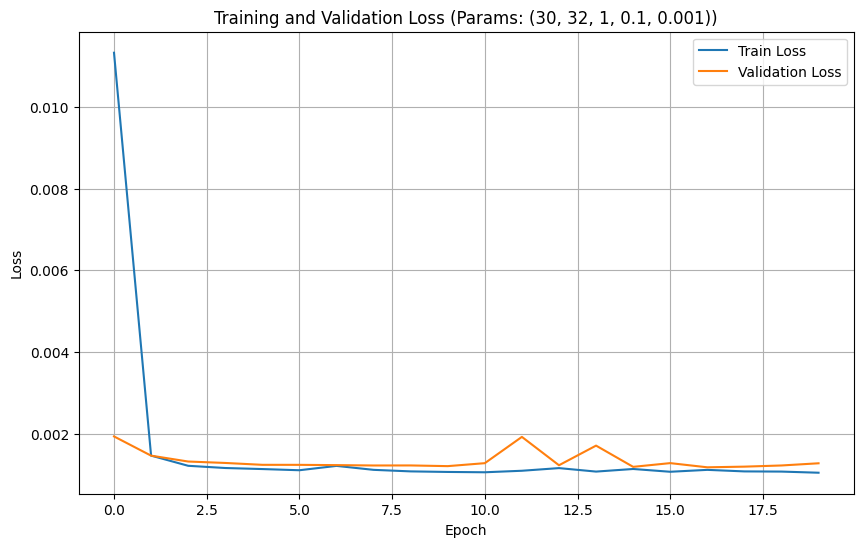

Testowanie kombinacji 2/48: (30, 32, 1, 0.1, 0.0001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0471, Val Loss: 0.0267, Duration: 0.27s
Epoch 2/20, Train Loss: 0.0096, Val Loss: 0.0021, Duration: 0.28s
Epoch 3/20, Train Loss: 0.0020, Val Loss: 0.0018, Duration: 0.30s
Epoch 4/20, Train Loss: 0.0017, Val Loss: 0.0017, Duration: 0.28s
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0016, Duration: 0.27s
Epoch 6/20, Train Loss: 0.0016, Val Loss: 0.0016, Duration: 0.27s
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.29s
Epoch 8/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.28s
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0014, Duration: 0.28s
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0014, Duration: 0.29s
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.30s
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.31s
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.28s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.29s
Epoch 15/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 0.28s
Epoc

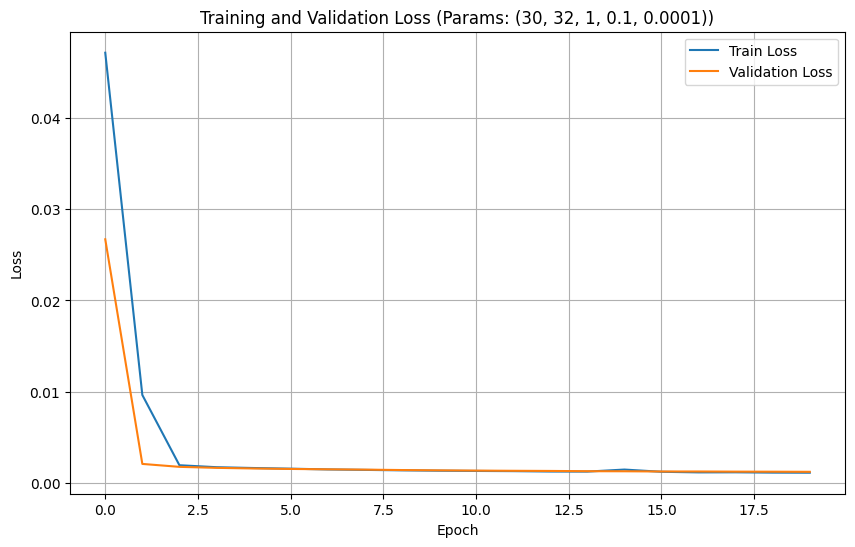

Testowanie kombinacji 3/48: (30, 32, 1, 0.2, 0.001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0116, Val Loss: 0.0016, Duration: 0.27s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.30s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.29s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.28s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.29s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.30s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.41s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.42s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.41s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 0.38s
Early stopping triggered at epoch 10


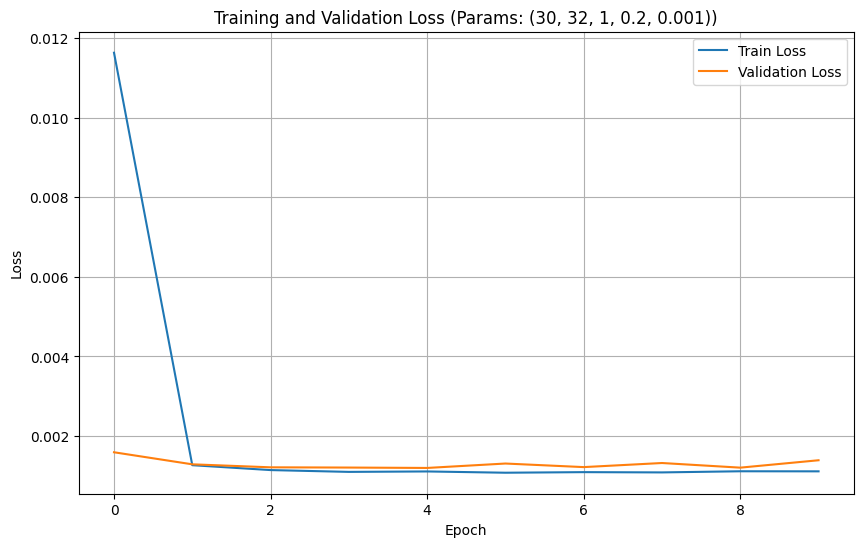

Testowanie kombinacji 4/48: (30, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0339, Val Loss: 0.0198, Duration: 0.39s
Epoch 2/20, Train Loss: 0.0079, Val Loss: 0.0030, Duration: 0.27s
Epoch 3/20, Train Loss: 0.0026, Val Loss: 0.0023, Duration: 0.28s
Epoch 4/20, Train Loss: 0.0020, Val Loss: 0.0018, Duration: 0.28s
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0016, Duration: 0.28s
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.28s
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.28s
Epoch 8/20, Train Loss: 0.0014, Val Loss: 0.0014, Duration: 0.30s
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.27s
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.28s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.29s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.30s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.29s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.29s
Epoch 15/20, Train

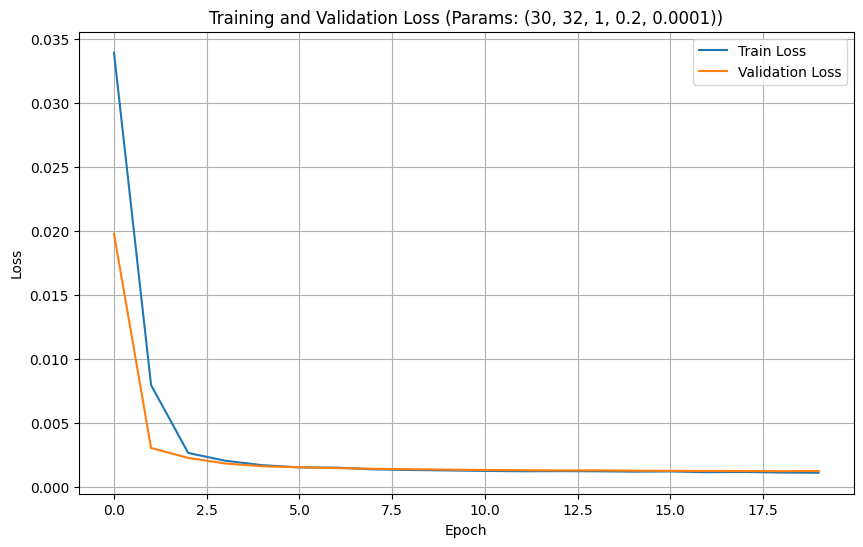

Testowanie kombinacji 5/48: (30, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0088, Val Loss: 0.0013, Duration: 0.69s
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.69s
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.69s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.69s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.67s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.85s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.95s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.03s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.84s
Early stopping triggered at epoch 9


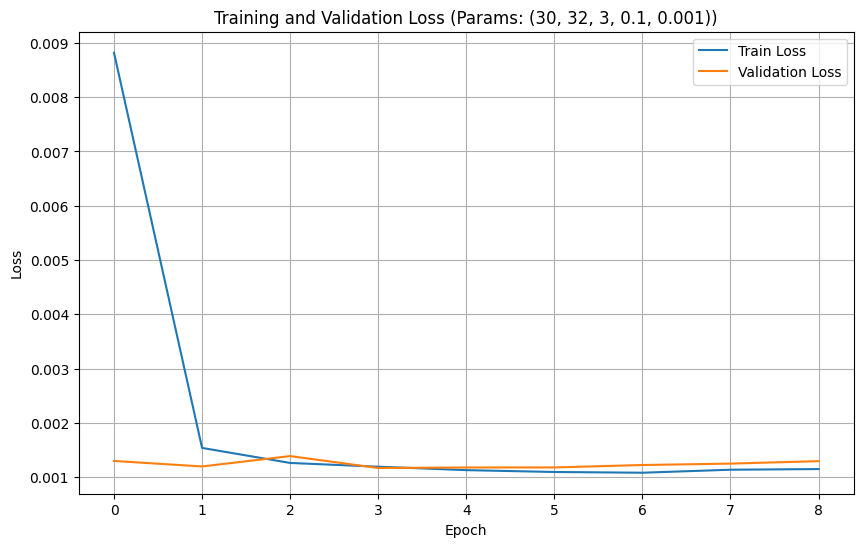

Testowanie kombinacji 6/48: (30, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0035, Val Loss: 0.0014, Duration: 0.70s
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 0.72s
Epoch 3/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 0.69s
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 0.68s
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.69s
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 0.73s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.71s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.66s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.66s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.67s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.67s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.68s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.80s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 1.07s
Epoch 15/20, Train

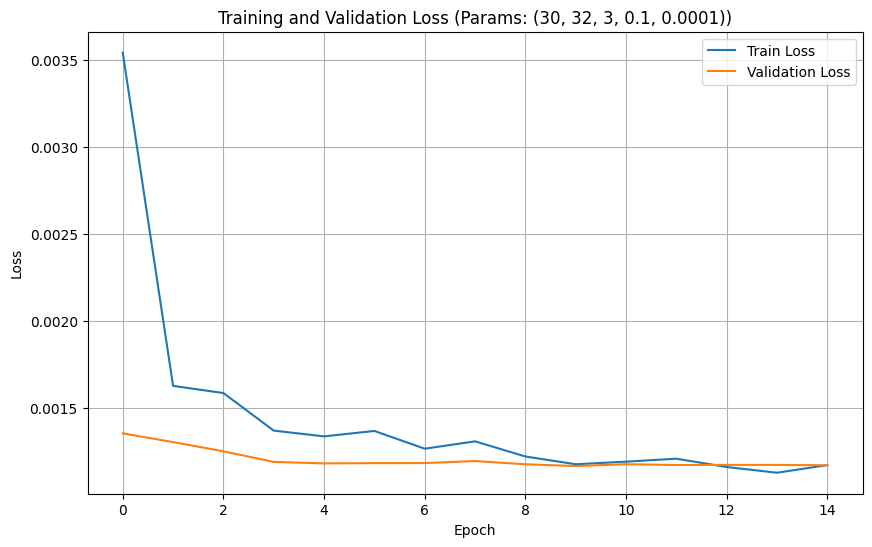

Testowanie kombinacji 7/48: (30, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0068, Val Loss: 0.0017, Duration: 0.69s
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.69s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.71s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.69s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.66s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.68s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.70s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.69s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.69s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.69s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.67s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.67s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.68s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.70s
Epoch 15/20, Train 

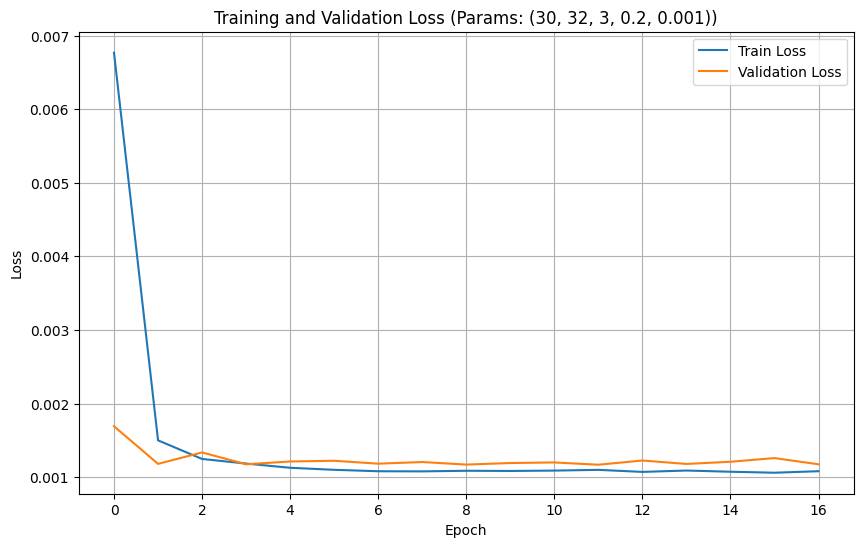

Testowanie kombinacji 8/48: (30, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0343, Val Loss: 0.0048, Duration: 0.66s
Epoch 2/20, Train Loss: 0.0038, Val Loss: 0.0014, Duration: 0.69s
Epoch 3/20, Train Loss: 0.0029, Val Loss: 0.0013, Duration: 0.68s
Epoch 4/20, Train Loss: 0.0025, Val Loss: 0.0013, Duration: 0.66s
Epoch 5/20, Train Loss: 0.0023, Val Loss: 0.0013, Duration: 0.67s
Epoch 6/20, Train Loss: 0.0020, Val Loss: 0.0013, Duration: 0.69s
Epoch 7/20, Train Loss: 0.0019, Val Loss: 0.0013, Duration: 0.68s
Epoch 8/20, Train Loss: 0.0017, Val Loss: 0.0013, Duration: 0.69s
Epoch 9/20, Train Loss: 0.0017, Val Loss: 0.0013, Duration: 0.69s
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.65s
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 0.68s
Epoch 12/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 0.73s
Epoch 13/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 0.69s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.69s
Epoch 15/20, Train

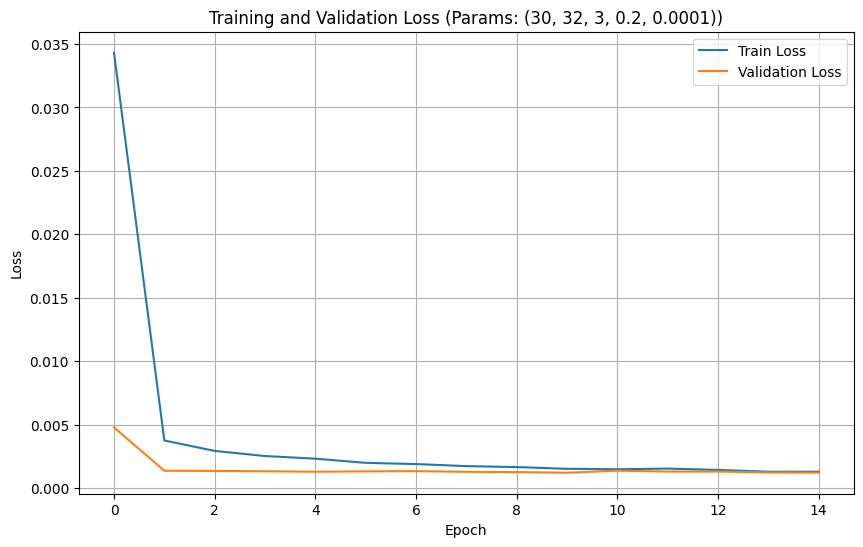

Testowanie kombinacji 9/48: (30, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0046, Val Loss: 0.0014, Duration: 0.53s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.42s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.34s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.34s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.33s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.33s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.34s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.33s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.34s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.34s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.33s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0017, Duration: 0.34s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.39s
Early stopping triggered at epoch 13


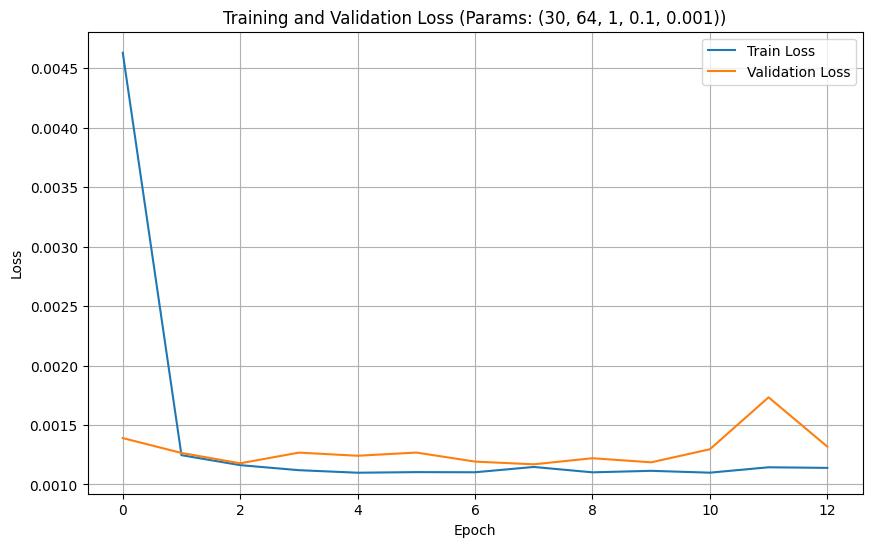

Testowanie kombinacji 10/48: (30, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0170, Val Loss: 0.0033, Duration: 0.33s
Epoch 2/20, Train Loss: 0.0023, Val Loss: 0.0018, Duration: 0.33s
Epoch 3/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 0.33s
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.35s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0014, Duration: 0.33s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.33s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.34s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.32s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.32s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.34s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.33s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 0.33s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.34s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.32s
Epoch 15/20, Trai

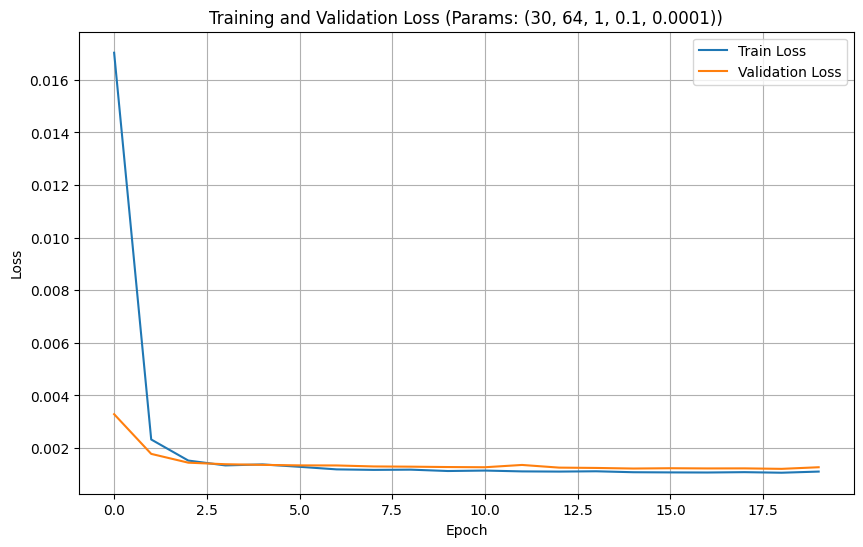

Testowanie kombinacji 11/48: (30, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0049, Val Loss: 0.0015, Duration: 0.33s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.34s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 0.34s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.33s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 0.34s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.35s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.33s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0015, Duration: 0.32s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0015, Duration: 0.33s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.35s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.33s
Early stopping triggered at epoch 11


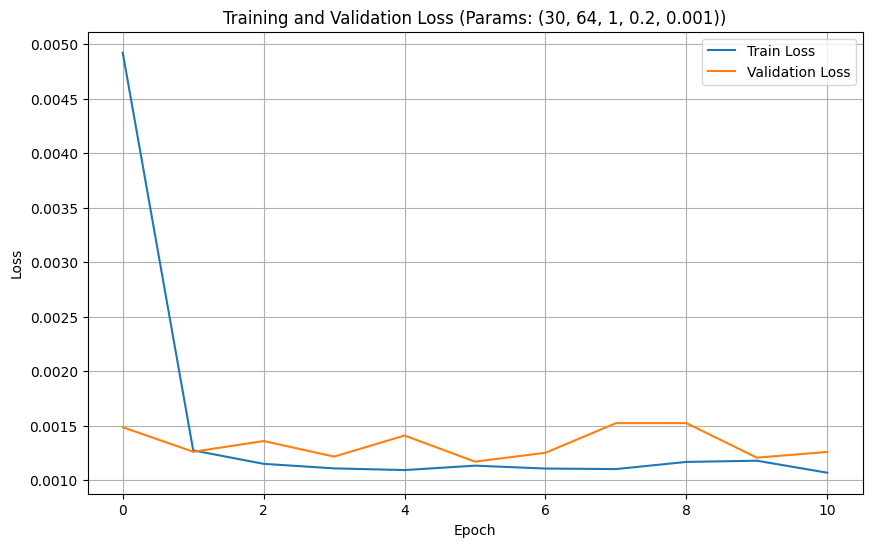

Testowanie kombinacji 12/48: (30, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0136, Val Loss: 0.0030, Duration: 0.35s
Epoch 2/20, Train Loss: 0.0024, Val Loss: 0.0018, Duration: 0.35s
Epoch 3/20, Train Loss: 0.0018, Val Loss: 0.0016, Duration: 0.36s
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.34s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0014, Duration: 0.35s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.34s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.34s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.34s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.34s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.33s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.33s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.34s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.34s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.35s
Epoch 15/20, Trai

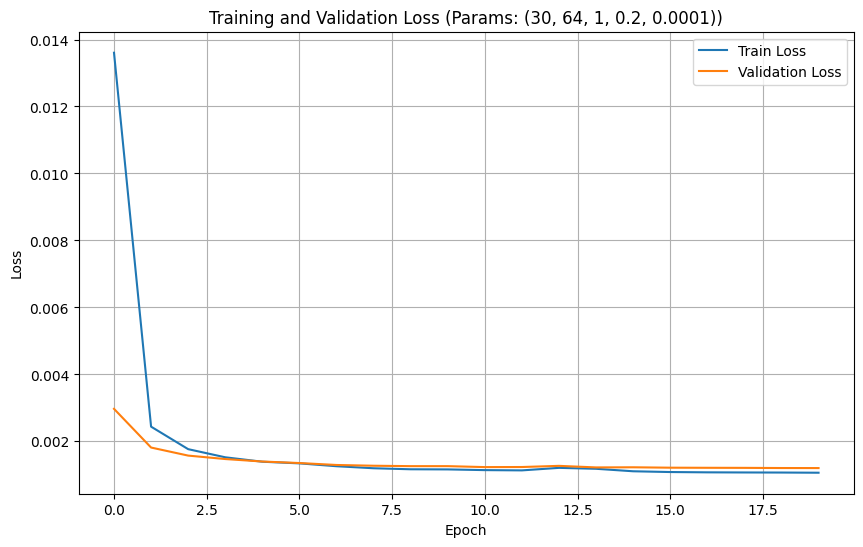

Testowanie kombinacji 13/48: (30, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0041, Val Loss: 0.0012, Duration: 0.89s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.85s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.86s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 0.86s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.90s
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0017, Duration: 0.90s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0015, Duration: 0.93s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0015, Duration: 0.88s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.91s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.88s
Early stopping triggered at epoch 10


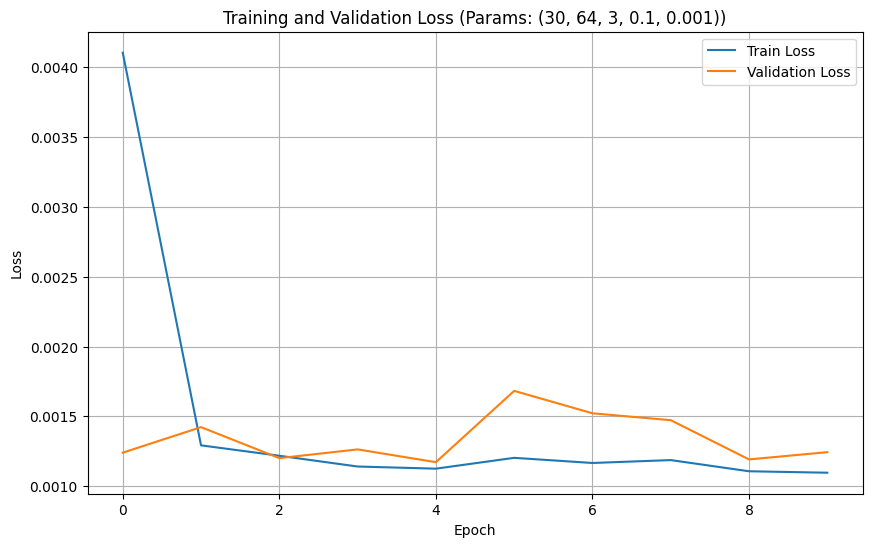

Testowanie kombinacji 14/48: (30, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0206, Val Loss: 0.0016, Duration: 1.10s
Epoch 2/20, Train Loss: 0.0017, Val Loss: 0.0014, Duration: 1.28s
Epoch 3/20, Train Loss: 0.0016, Val Loss: 0.0012, Duration: 1.39s
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.88s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 0.88s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.88s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.88s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.90s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.87s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.86s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.87s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.88s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.86s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.87s
Epoch 15/20, Trai

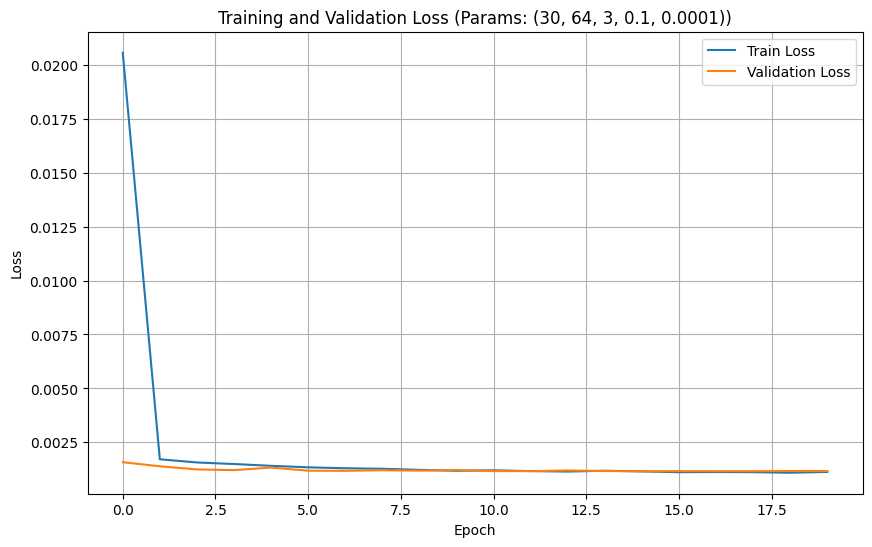

Testowanie kombinacji 15/48: (30, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0050, Val Loss: 0.0012, Duration: 0.89s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.88s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.89s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.89s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.90s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0020, Duration: 0.85s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.91s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.20s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0016, Duration: 1.41s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 1.28s
Early stopping triggered at epoch 10


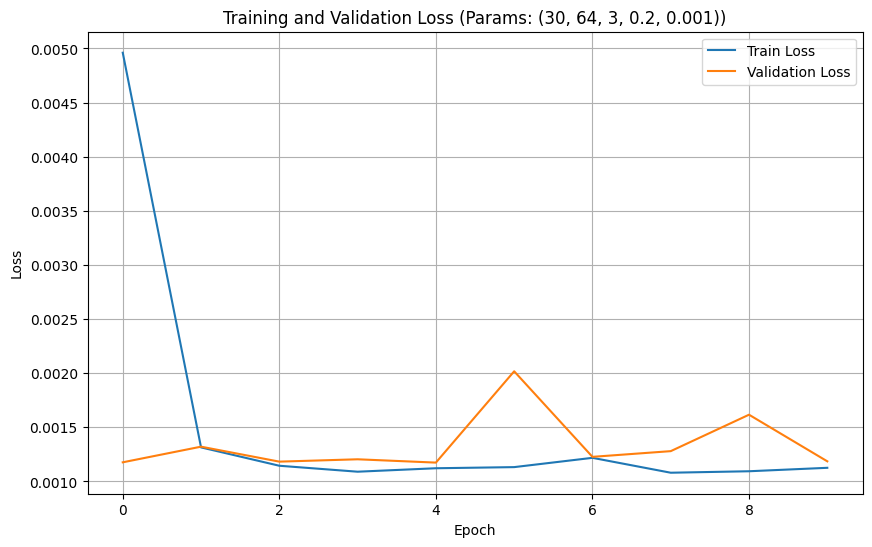

Testowanie kombinacji 16/48: (30, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0094, Val Loss: 0.0016, Duration: 0.87s
Epoch 2/20, Train Loss: 0.0024, Val Loss: 0.0014, Duration: 0.90s
Epoch 3/20, Train Loss: 0.0021, Val Loss: 0.0013, Duration: 0.90s
Epoch 4/20, Train Loss: 0.0017, Val Loss: 0.0012, Duration: 0.92s
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0012, Duration: 0.90s
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.89s
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 0.97s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.88s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.86s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.87s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 1.23s
Early stopping triggered at epoch 11


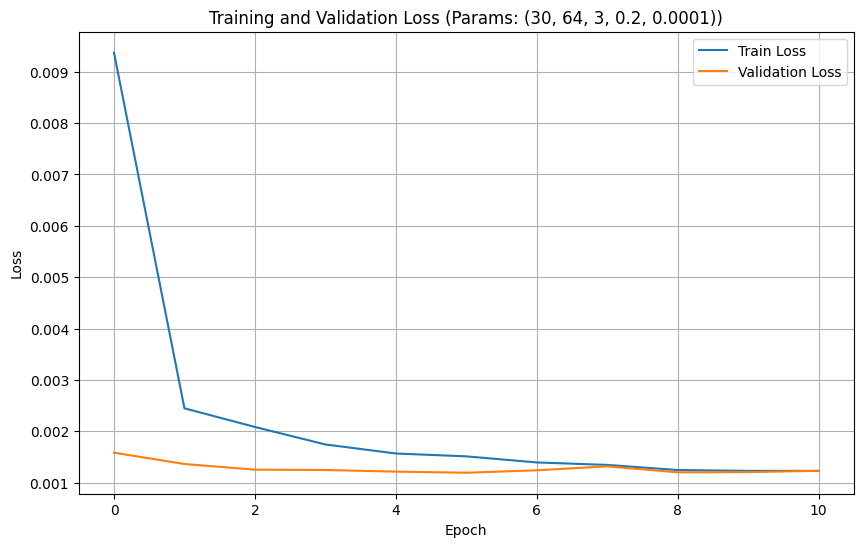

Testowanie kombinacji 17/48: (100, 32, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0099, Val Loss: 0.0019, Duration: 0.67s
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0012, Duration: 0.68s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.68s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.68s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.68s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.72s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.70s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.67s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.69s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.69s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.68s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.68s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.68s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.73s
Epoch 15/20, Trai

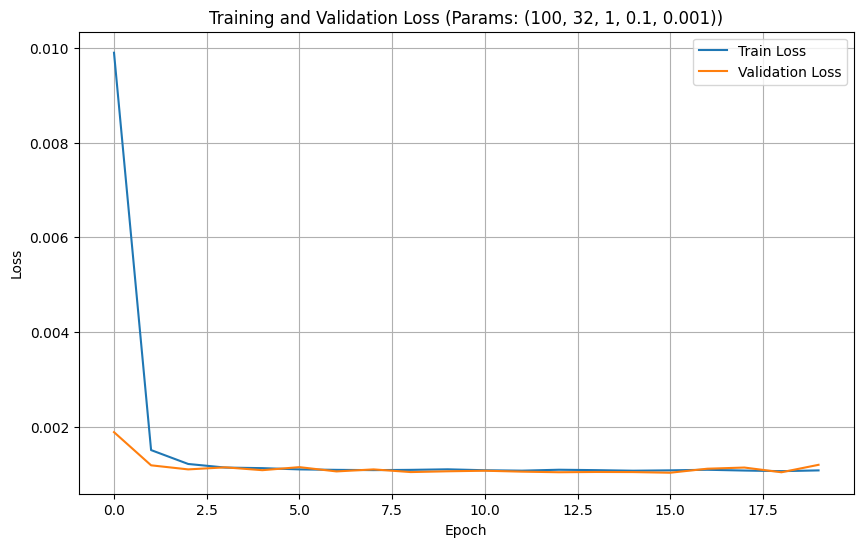

Testowanie kombinacji 18/48: (100, 32, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0286, Val Loss: 0.0143, Duration: 0.67s
Epoch 2/20, Train Loss: 0.0045, Val Loss: 0.0019, Duration: 0.66s
Epoch 3/20, Train Loss: 0.0017, Val Loss: 0.0017, Duration: 0.72s
Epoch 4/20, Train Loss: 0.0016, Val Loss: 0.0016, Duration: 0.67s
Epoch 5/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 0.67s
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0015, Duration: 0.67s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.66s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 0.67s
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 0.70s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 0.99s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 1.00s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 1.06s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.75s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.68s
Epoch 15/20, Tra

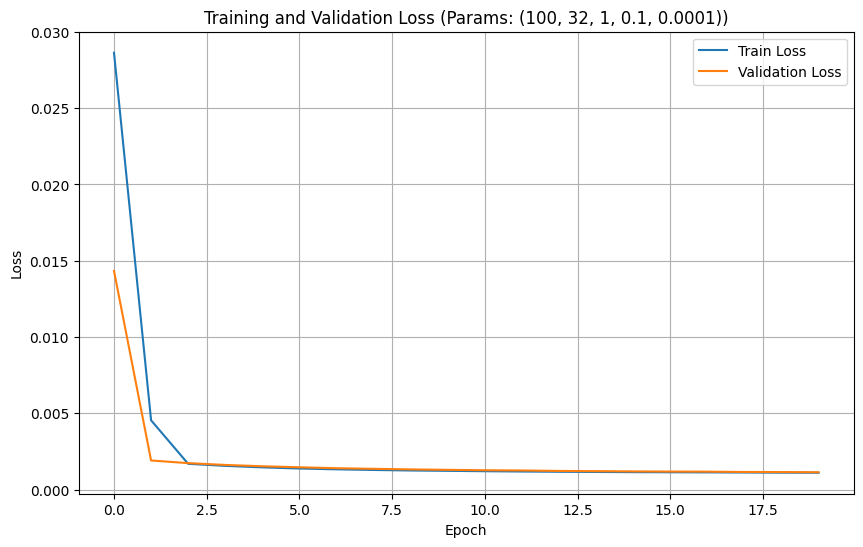

Testowanie kombinacji 19/48: (100, 32, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0109, Val Loss: 0.0017, Duration: 0.69s
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 0.70s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.69s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.67s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.98s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.96s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 1.02s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.78s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.68s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.67s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 0.67s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.67s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.69s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.68s
Epoch 15/20, Trai

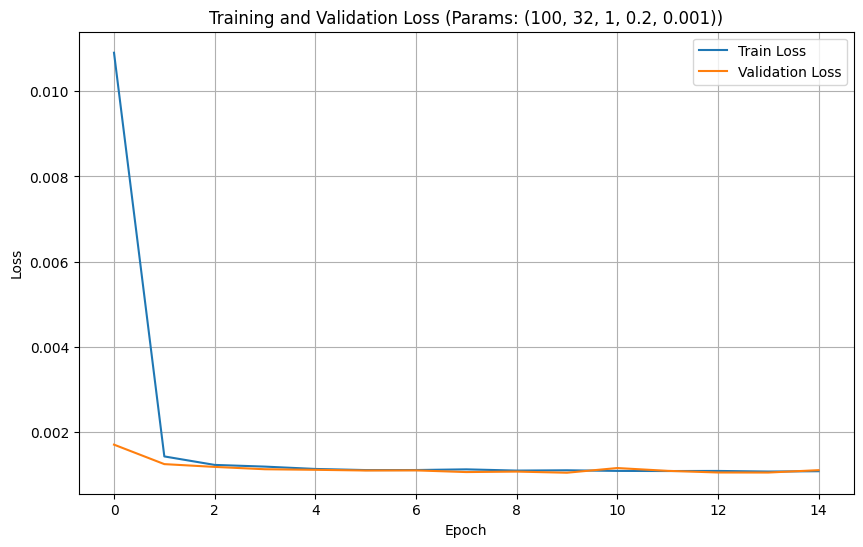

Testowanie kombinacji 20/48: (100, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0229, Val Loss: 0.0080, Duration: 0.68s
Epoch 2/20, Train Loss: 0.0030, Val Loss: 0.0020, Duration: 0.68s
Epoch 3/20, Train Loss: 0.0020, Val Loss: 0.0018, Duration: 0.67s
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0017, Duration: 0.68s
Epoch 5/20, Train Loss: 0.0018, Val Loss: 0.0016, Duration: 0.85s
Epoch 6/20, Train Loss: 0.0017, Val Loss: 0.0015, Duration: 0.93s
Epoch 7/20, Train Loss: 0.0016, Val Loss: 0.0014, Duration: 1.05s
Epoch 8/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 0.92s
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 0.74s
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 0.79s
Epoch 11/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 0.67s
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.66s
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.68s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 0.68s
Epoch 15/20, Tra

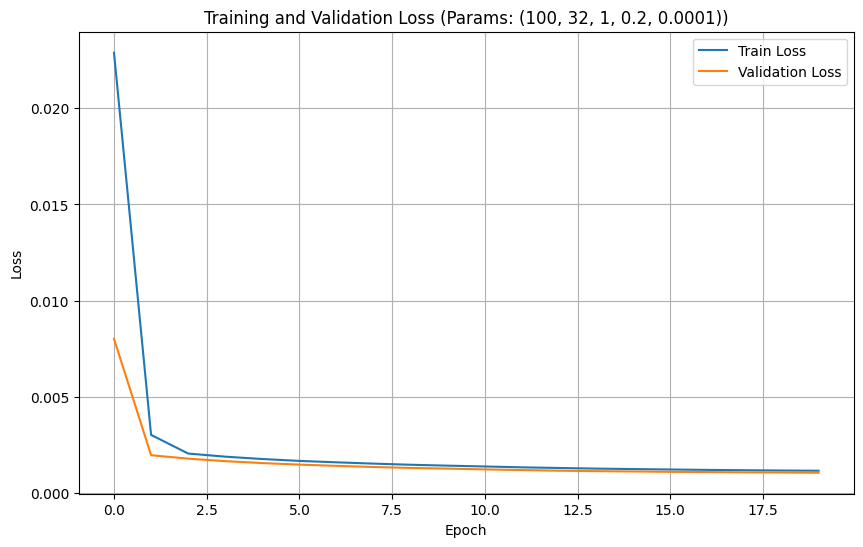

Testowanie kombinacji 21/48: (100, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0022, Val Loss: 0.0010, Duration: 2.82s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.02s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.97s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.02s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.93s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.06s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.85s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.00s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.92s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.97s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.96s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.87s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.55s
Early stopping triggered at epoch 13


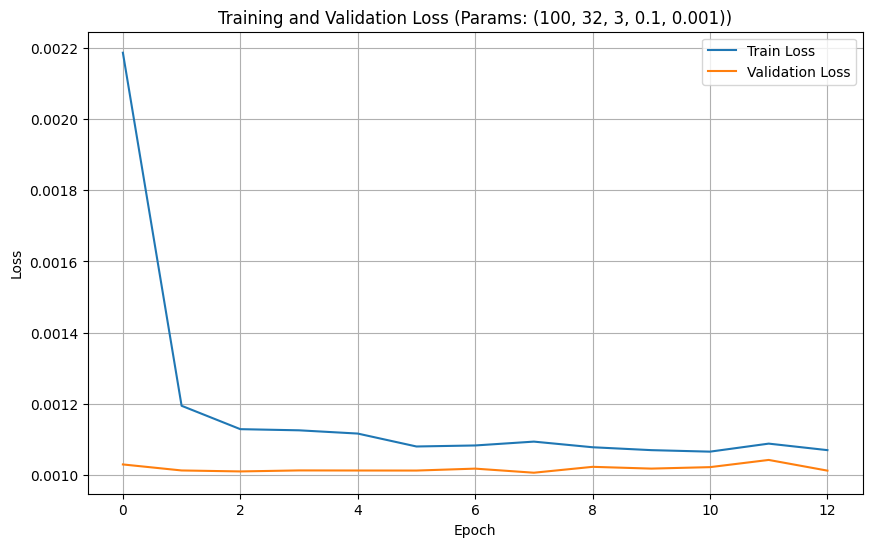

Testowanie kombinacji 22/48: (100, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0390, Val Loss: 0.0018, Duration: 1.94s
Epoch 2/20, Train Loss: 0.0025, Val Loss: 0.0012, Duration: 1.96s
Epoch 3/20, Train Loss: 0.0022, Val Loss: 0.0012, Duration: 1.95s
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0012, Duration: 1.91s
Epoch 5/20, Train Loss: 0.0019, Val Loss: 0.0011, Duration: 2.22s
Epoch 6/20, Train Loss: 0.0018, Val Loss: 0.0011, Duration: 2.68s
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0011, Duration: 1.90s
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0011, Duration: 1.92s
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 2.00s
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 2.10s
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 2.50s
Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 3.06s
Epoch 13/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 2.56s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.64s
Epoch 15/20, Tra

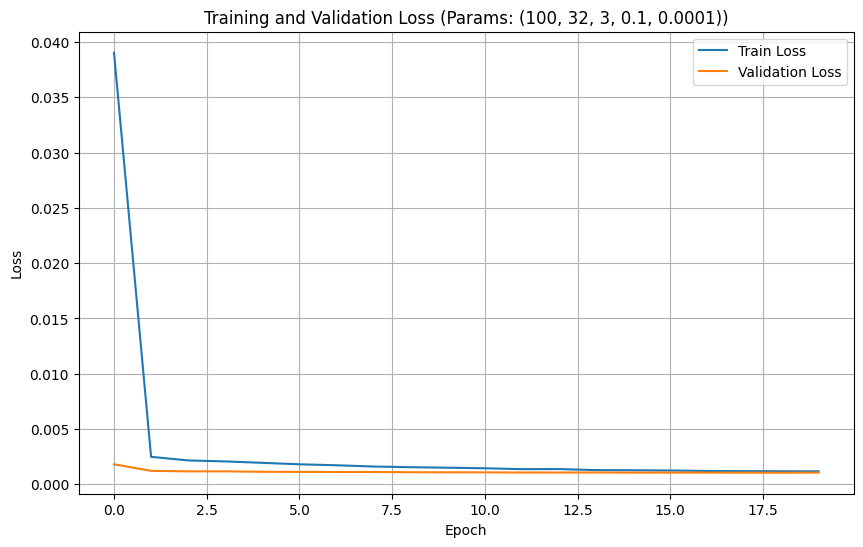

Testowanie kombinacji 23/48: (100, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0078, Val Loss: 0.0014, Duration: 1.95s
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0011, Duration: 1.93s
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 2.11s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.30s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 3.21s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.67s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.54s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.66s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.91s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 3.46s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.67s
Early stopping triggered at epoch 11


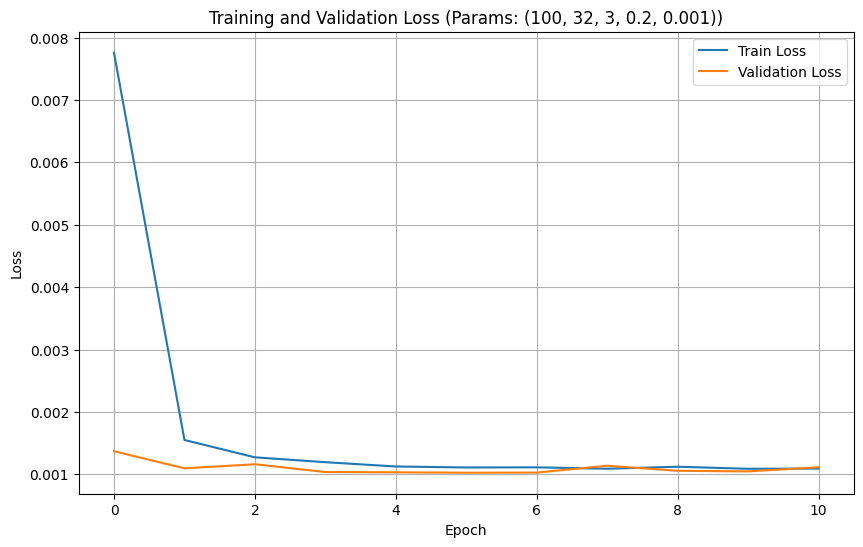

Testowanie kombinacji 24/48: (100, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0123, Val Loss: 0.0017, Duration: 1.94s
Epoch 2/20, Train Loss: 0.0021, Val Loss: 0.0011, Duration: 2.05s
Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0011, Duration: 2.57s
Epoch 4/20, Train Loss: 0.0017, Val Loss: 0.0011, Duration: 2.65s
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0010, Duration: 2.07s
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0010, Duration: 2.06s
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0010, Duration: 2.11s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.10s
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0010, Duration: 2.90s
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0010, Duration: 2.64s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 2.18s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.16s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.21s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.26s
Epoch 15/20, Tra

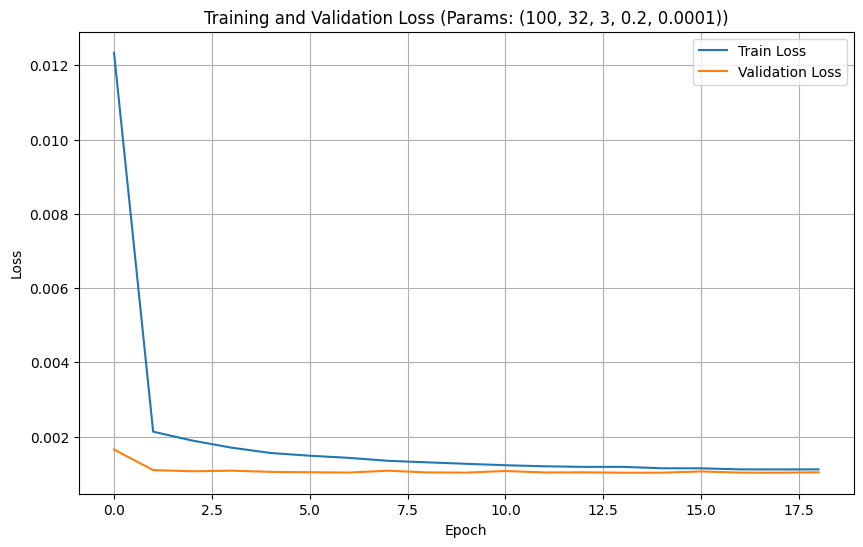

Testowanie kombinacji 25/48: (100, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0025, Val Loss: 0.0011, Duration: 1.13s
Epoch 2/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.85s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.93s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.85s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.83s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.83s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.84s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.87s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.87s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.86s
Early stopping triggered at epoch 10


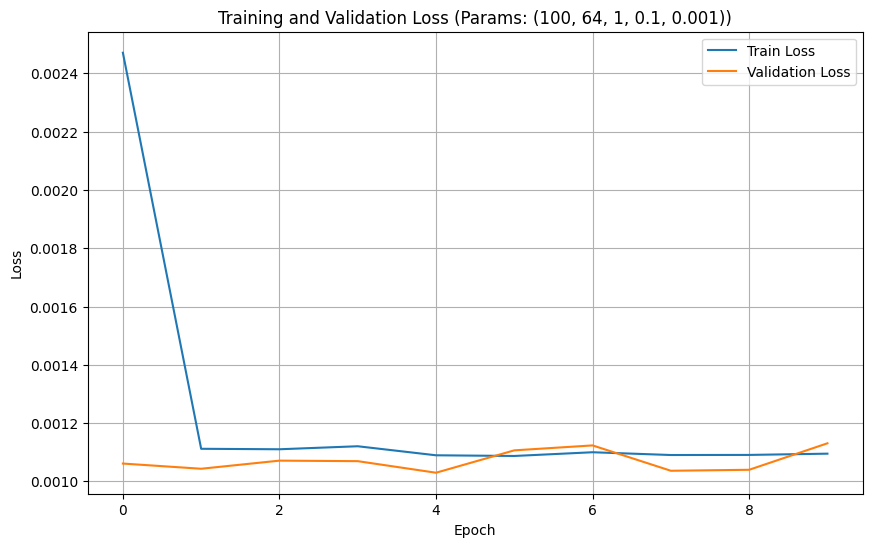

Testowanie kombinacji 26/48: (100, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0403, Val Loss: 0.0137, Duration: 1.15s
Epoch 2/20, Train Loss: 0.0044, Val Loss: 0.0029, Duration: 1.30s
Epoch 3/20, Train Loss: 0.0025, Val Loss: 0.0021, Duration: 1.25s
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0017, Duration: 0.84s
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0015, Duration: 0.81s
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 0.84s
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 0.87s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.88s
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.85s
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 0.86s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.86s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.85s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.83s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.86s
Epoch 15/20, Tra

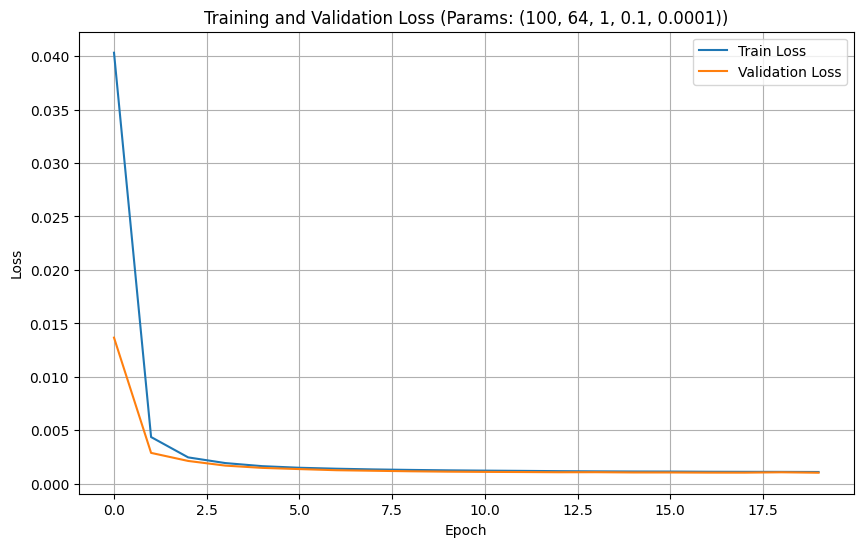

Testowanie kombinacji 27/48: (100, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0082, Val Loss: 0.0013, Duration: 0.85s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 0.89s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 0.88s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.84s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.85s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.84s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.99s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.20s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 1.28s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 0.96s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.86s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.88s
Early stopping triggered at epoch 12


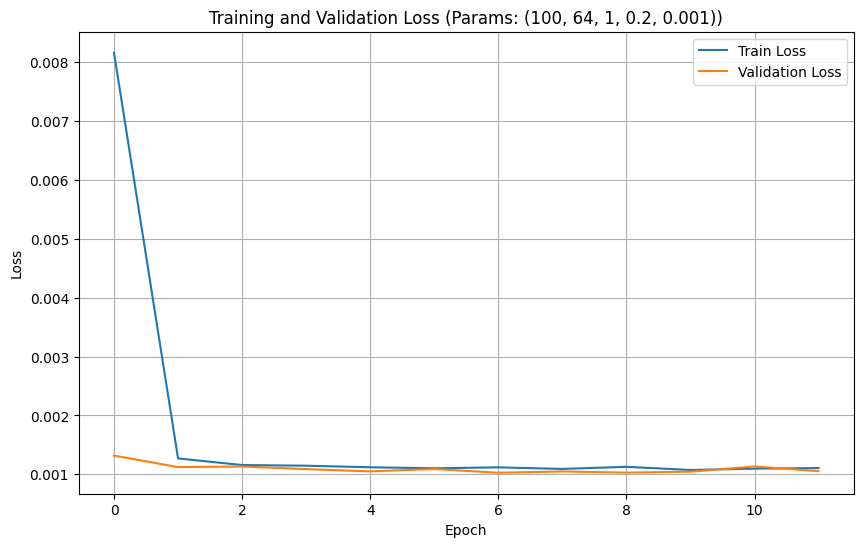

Testowanie kombinacji 28/48: (100, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0201, Val Loss: 0.0023, Duration: 0.83s
Epoch 2/20, Train Loss: 0.0018, Val Loss: 0.0015, Duration: 0.86s
Epoch 3/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 0.87s
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 0.85s
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.87s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 0.89s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 0.93s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 1.19s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 1.30s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 1.12s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.85s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.88s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.85s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 0.87s
Epoch 15/20, Tra

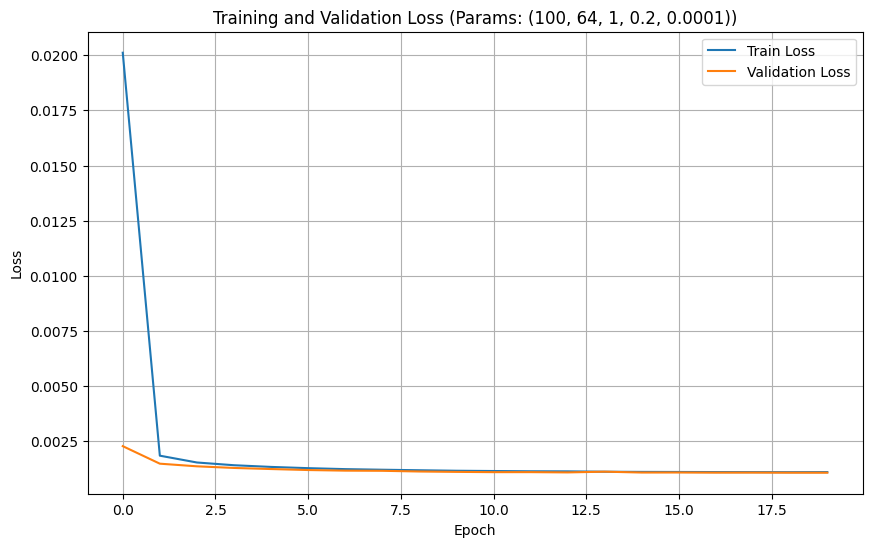

Testowanie kombinacji 29/48: (100, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0046, Val Loss: 0.0011, Duration: 3.23s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.65s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.80s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.61s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 3.79s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.71s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.72s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.72s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 3.01s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 3.48s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.64s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.67s
Early stopping triggered at epoch 12


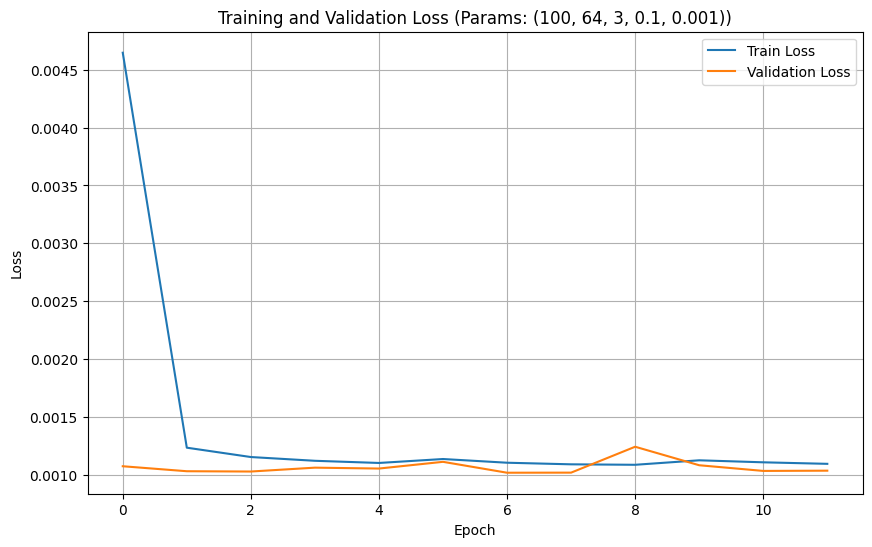

Testowanie kombinacji 30/48: (100, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0155, Val Loss: 0.0014, Duration: 3.12s
Epoch 2/20, Train Loss: 0.0017, Val Loss: 0.0012, Duration: 3.25s
Epoch 3/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 2.69s
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 2.71s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 2.65s
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 3.66s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.66s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.70s
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.67s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 3.03s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 3.37s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.60s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.63s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 2.69s
Epoch 15/20, Tra

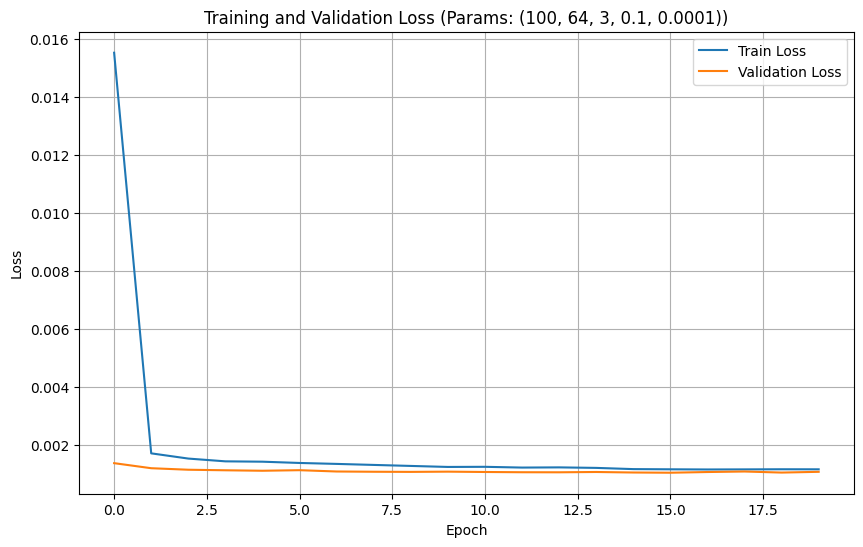

Testowanie kombinacji 31/48: (100, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0034, Val Loss: 0.0011, Duration: 2.66s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 2.66s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 3.03s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 3.39s
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.69s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.66s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.67s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 3.56s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.85s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011, Duration: 2.68s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.65s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 2.76s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010, Duration: 3.53s
Early stopping triggered at epoch 13


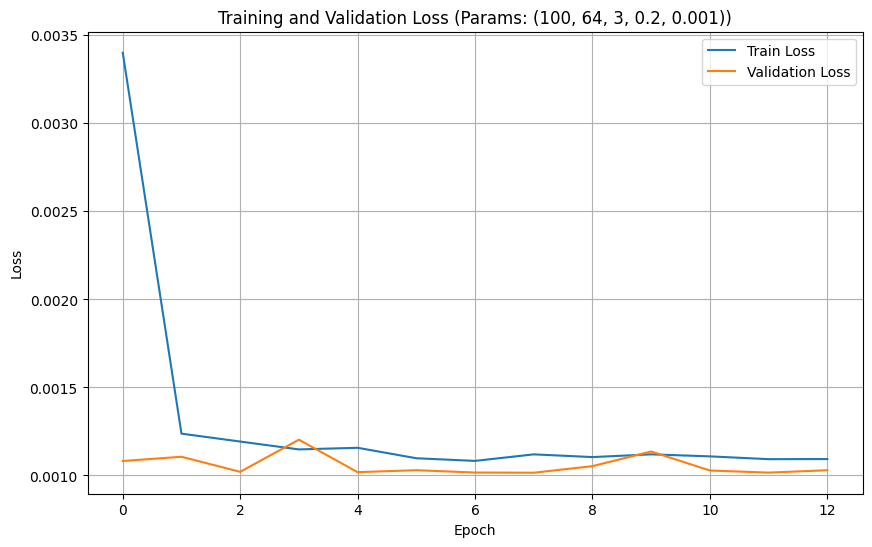

Testowanie kombinacji 32/48: (100, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0121, Val Loss: 0.0012, Duration: 2.66s
Epoch 2/20, Train Loss: 0.0018, Val Loss: 0.0012, Duration: 2.70s
Epoch 3/20, Train Loss: 0.0016, Val Loss: 0.0011, Duration: 2.95s
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 3.54s
Epoch 5/20, Train Loss: 0.0015, Val Loss: 0.0011, Duration: 2.68s
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0011, Duration: 2.68s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0011, Duration: 2.73s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 3.57s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 2.78s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 2.69s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.70s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 3.12s
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0011, Duration: 3.38s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0010, Duration: 2.73s
Epoch 15/20, Tra

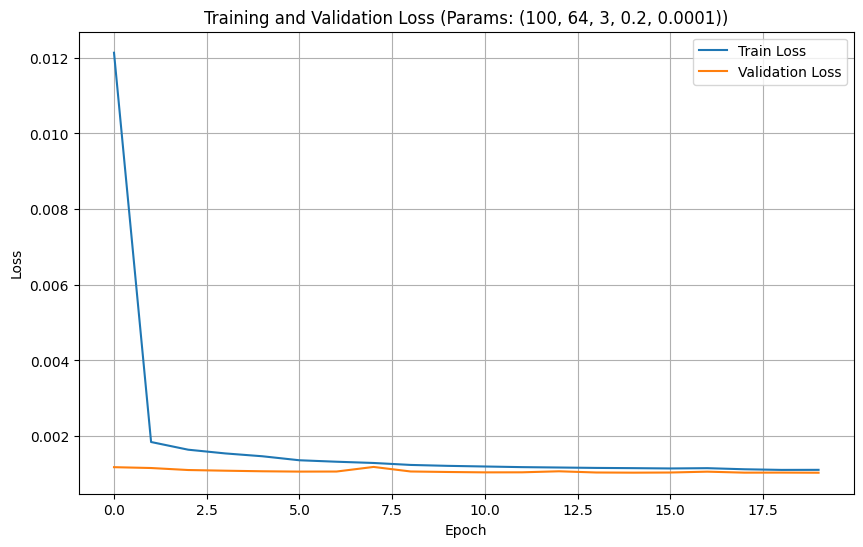

Testowanie kombinacji 33/48: (150, 32, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0045, Val Loss: 0.0014, Duration: 2.54s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 2.15s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.10s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 2.13s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.17s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.46s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.59s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.19s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.20s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.15s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.19s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 2.67s
Early stopping triggered at epoch 12


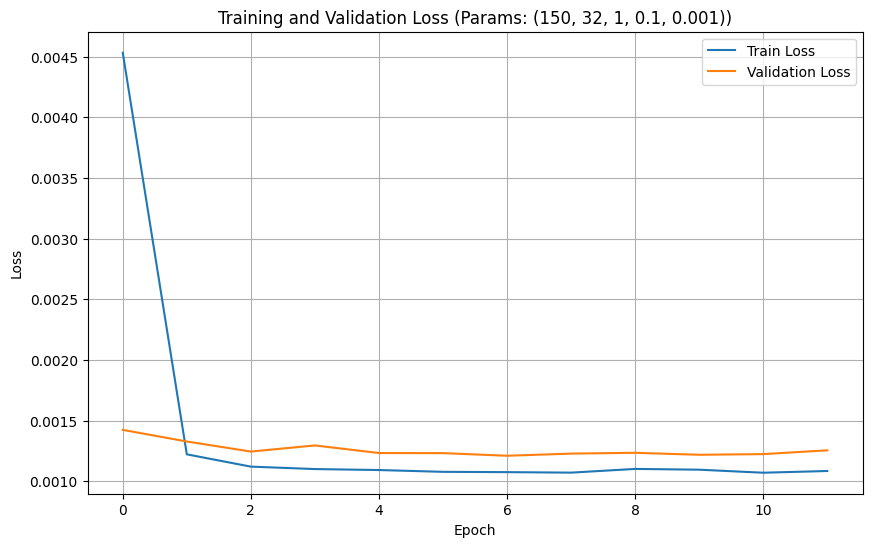

Testowanie kombinacji 34/48: (150, 32, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0638, Val Loss: 0.0490, Duration: 1.86s
Epoch 2/20, Train Loss: 0.0313, Val Loss: 0.0085, Duration: 1.27s
Epoch 3/20, Train Loss: 0.0032, Val Loss: 0.0024, Duration: 1.48s
Epoch 4/20, Train Loss: 0.0023, Val Loss: 0.0022, Duration: 1.52s
Epoch 5/20, Train Loss: 0.0021, Val Loss: 0.0020, Duration: 1.49s
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0019, Duration: 1.87s
Epoch 7/20, Train Loss: 0.0018, Val Loss: 0.0018, Duration: 1.88s
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0017, Duration: 1.47s
Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0016, Duration: 1.50s
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0016, Duration: 1.49s
Epoch 11/20, Train Loss: 0.0014, Val Loss: 0.0016, Duration: 1.52s
Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0015, Duration: 1.54s
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 1.52s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 1.94s
Epoch 15/20, Tra

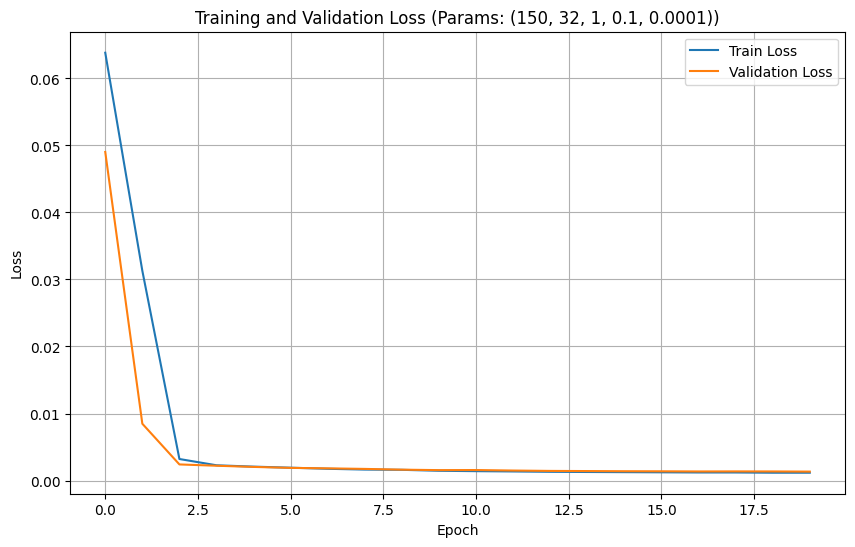

Testowanie kombinacji 35/48: (150, 32, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0082, Val Loss: 0.0018, Duration: 0.99s
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0014, Duration: 1.45s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 1.74s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 1.78s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.81s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 1.90s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.49s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 2.00s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.99s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.08s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.11s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0015, Duration: 2.06s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 2.58s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 2.12s
Epoch 15/20, Trai

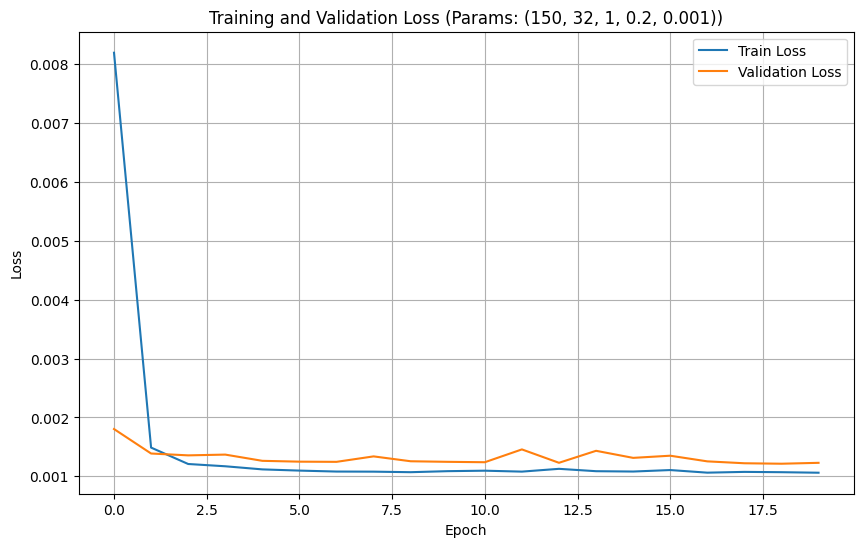

Testowanie kombinacji 36/48: (150, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0345, Val Loss: 0.0193, Duration: 0.93s
Epoch 2/20, Train Loss: 0.0091, Val Loss: 0.0045, Duration: 1.12s
Epoch 3/20, Train Loss: 0.0040, Val Loss: 0.0033, Duration: 1.43s
Epoch 4/20, Train Loss: 0.0031, Val Loss: 0.0025, Duration: 1.56s
Epoch 5/20, Train Loss: 0.0023, Val Loss: 0.0020, Duration: 1.95s
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0017, Duration: 2.31s
Epoch 7/20, Train Loss: 0.0016, Val Loss: 0.0016, Duration: 1.89s
Epoch 8/20, Train Loss: 0.0015, Val Loss: 0.0015, Duration: 2.01s
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0015, Duration: 2.03s
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 2.17s
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 2.42s
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 2.66s
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 2.21s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 2.34s
Epoch 15/20, Tra

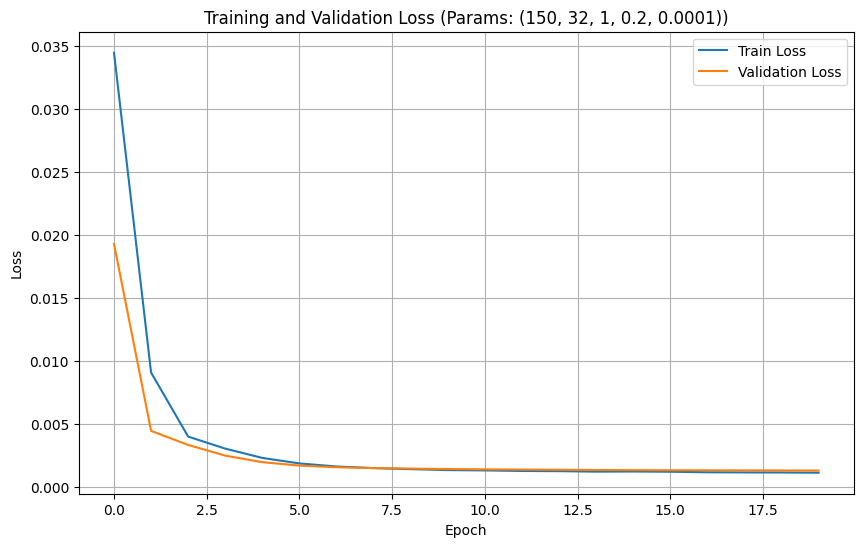

Testowanie kombinacji 37/48: (150, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0035, Val Loss: 0.0012, Duration: 7.02s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 6.27s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 6.89s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 6.38s
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 6.89s
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 6.31s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 6.80s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 6.20s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 6.99s
Early stopping triggered at epoch 9


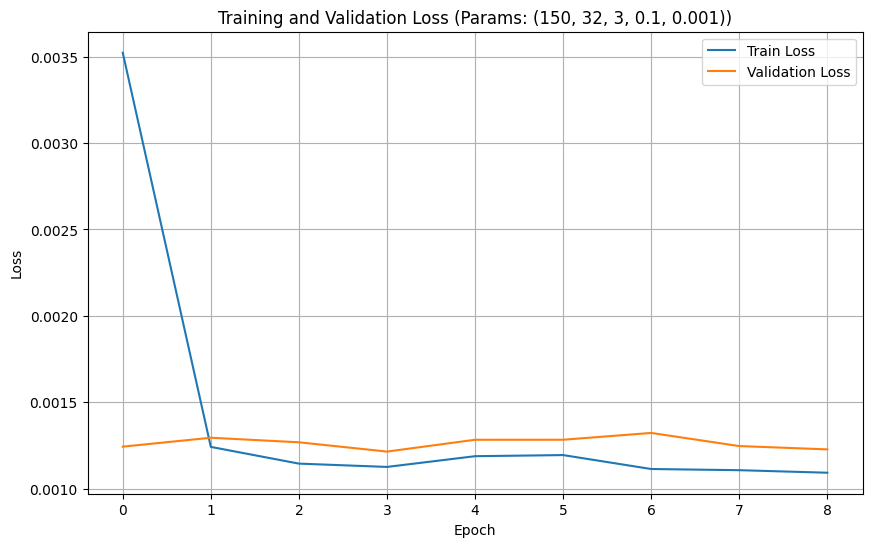

Testowanie kombinacji 38/48: (150, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0284, Val Loss: 0.0014, Duration: 6.74s
Epoch 2/20, Train Loss: 0.0023, Val Loss: 0.0014, Duration: 7.03s
Epoch 3/20, Train Loss: 0.0020, Val Loss: 0.0013, Duration: 7.54s
Epoch 4/20, Train Loss: 0.0018, Val Loss: 0.0013, Duration: 6.98s
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0013, Duration: 7.57s
Epoch 6/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 7.41s
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 7.48s
Epoch 8/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 7.90s
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 6.98s
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 7.67s
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 7.05s
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 7.74s
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 7.64s
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 7.17s
Epoch 15/20, Tra

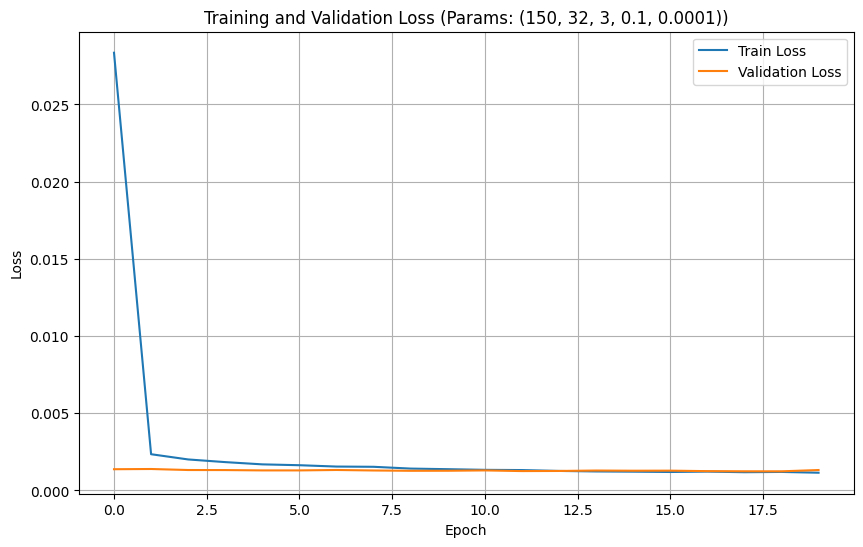

Testowanie kombinacji 39/48: (150, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0060, Val Loss: 0.0012, Duration: 4.93s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 5.87s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 5.33s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 5.55s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 5.83s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 5.21s
Early stopping triggered at epoch 6


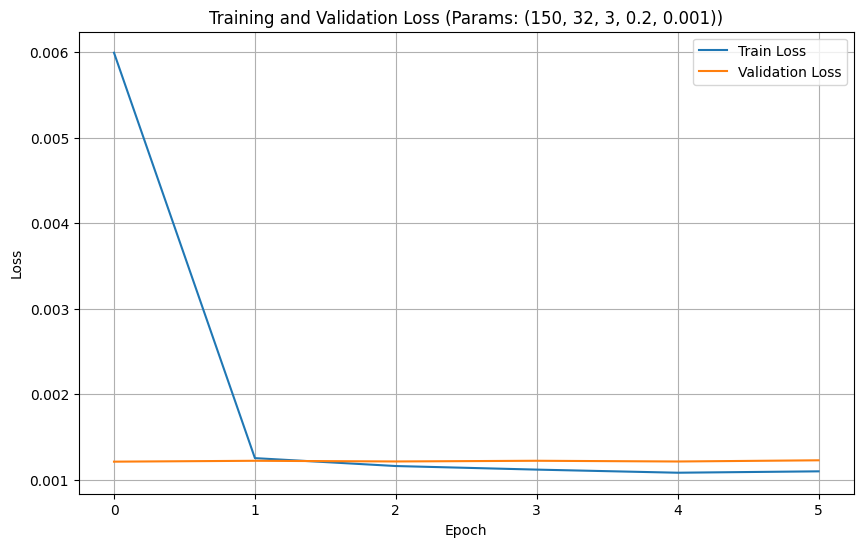

Testowanie kombinacji 40/48: (150, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0195, Val Loss: 0.0026, Duration: 4.46s
Epoch 2/20, Train Loss: 0.0032, Val Loss: 0.0016, Duration: 4.50s
Epoch 3/20, Train Loss: 0.0028, Val Loss: 0.0015, Duration: 5.16s
Epoch 4/20, Train Loss: 0.0024, Val Loss: 0.0014, Duration: 4.45s
Epoch 5/20, Train Loss: 0.0022, Val Loss: 0.0014, Duration: 4.64s
Epoch 6/20, Train Loss: 0.0020, Val Loss: 0.0013, Duration: 4.87s
Epoch 7/20, Train Loss: 0.0018, Val Loss: 0.0013, Duration: 4.30s
Epoch 8/20, Train Loss: 0.0017, Val Loss: 0.0013, Duration: 4.71s
Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 4.62s
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 4.37s
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 5.22s
Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 4.44s
Epoch 13/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 4.54s
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0013, Duration: 5.17s
Epoch 15/20, Tra

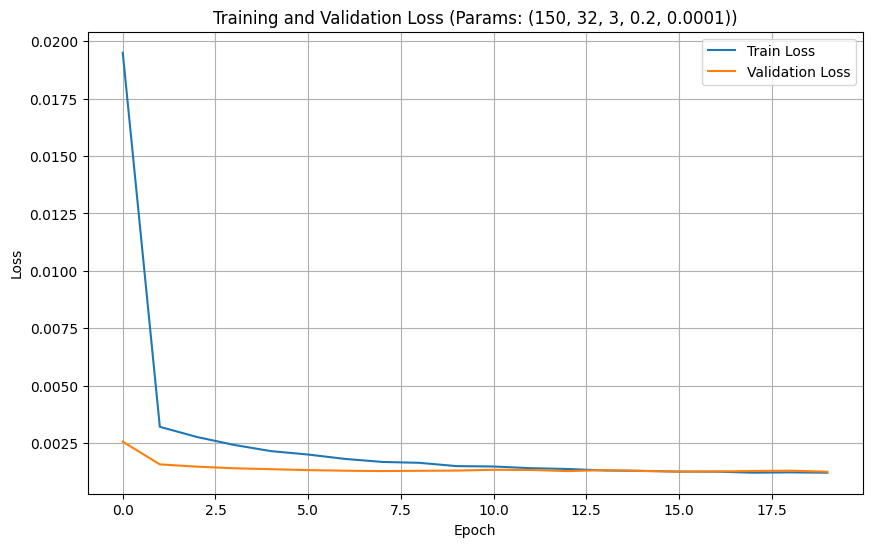

Testowanie kombinacji 41/48: (150, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0074, Val Loss: 0.0015, Duration: 2.65s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 4.42s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 3.88s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 3.81s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0015, Duration: 4.29s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 4.24s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 4.16s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 4.77s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 4.24s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 4.19s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 4.97s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 4.12s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 4.45s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 4.79s
Epoch 15/20, Trai

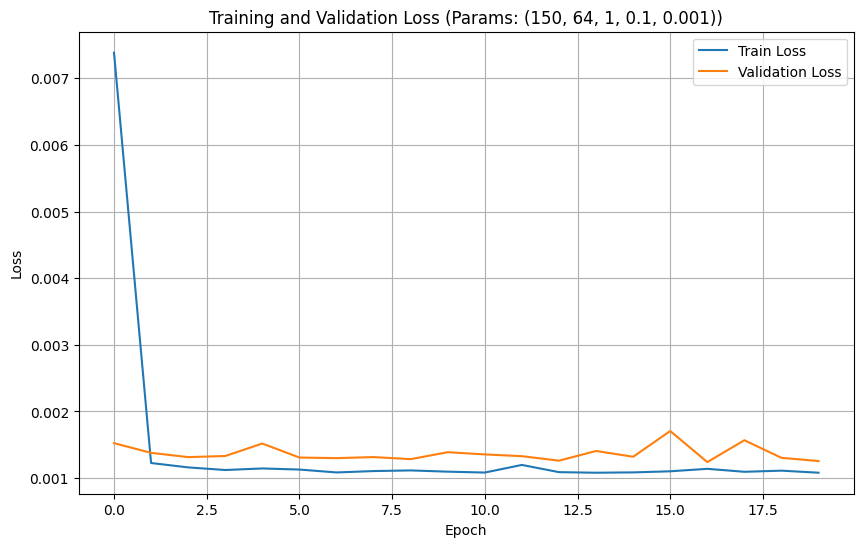

Testowanie kombinacji 42/48: (150, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0259, Val Loss: 0.0028, Duration: 3.51s
Epoch 2/20, Train Loss: 0.0019, Val Loss: 0.0016, Duration: 4.89s
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0015, Duration: 4.35s
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 3.32s
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 2.54s
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 2.50s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 2.23s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 1.55s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.48s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.33s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 1.32s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.26s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.22s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 1.32s
Epoch 15/20, Tra

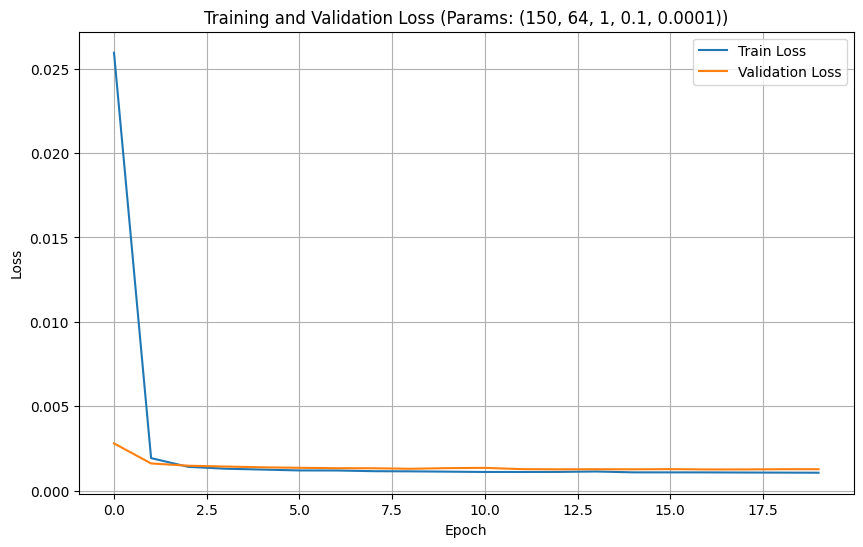

Testowanie kombinacji 43/48: (150, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0078, Val Loss: 0.0015, Duration: 5.50s
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 5.40s
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 5.75s
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 5.56s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 5.36s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 5.87s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 5.39s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 5.95s
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 5.24s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0015, Duration: 5.40s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 5.01s
Early stopping triggered at epoch 11


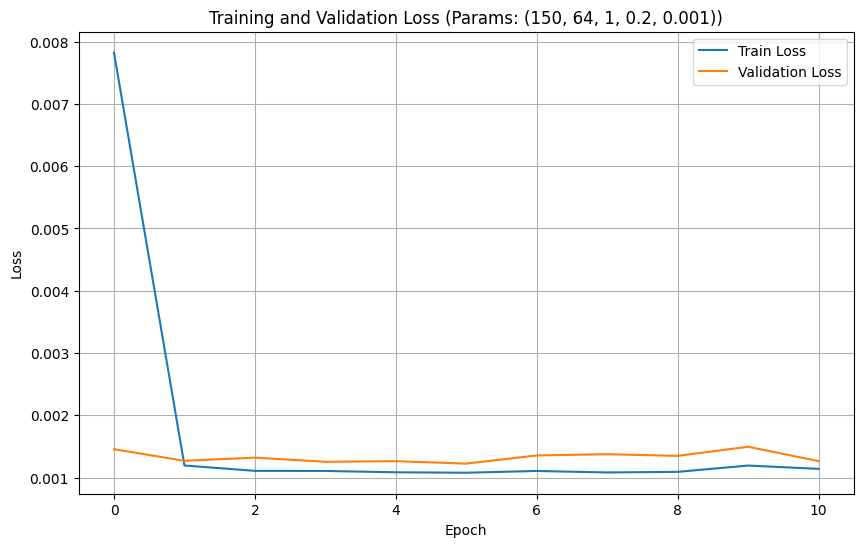

Testowanie kombinacji 44/48: (150, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0158, Val Loss: 0.0030, Duration: 2.24s
Epoch 2/20, Train Loss: 0.0022, Val Loss: 0.0019, Duration: 3.71s
Epoch 3/20, Train Loss: 0.0017, Val Loss: 0.0017, Duration: 3.17s
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0016, Duration: 3.26s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0015, Duration: 3.25s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0015, Duration: 3.90s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 3.37s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 3.56s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0014, Duration: 3.97s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 3.80s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 3.39s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 3.30s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 3.83s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 3.22s
Epoch 15/20, Tra

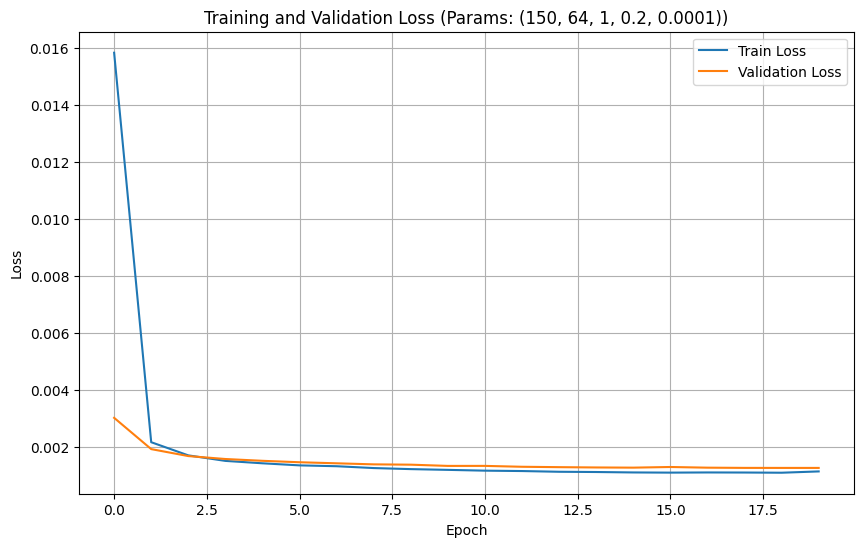

Testowanie kombinacji 45/48: (150, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0047, Val Loss: 0.0015, Duration: 16.24s
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 16.52s
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 15.24s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 14.88s
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 13.00s
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 13.04s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 14.36s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0014, Duration: 13.05s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 14.32s
Early stopping triggered at epoch 9


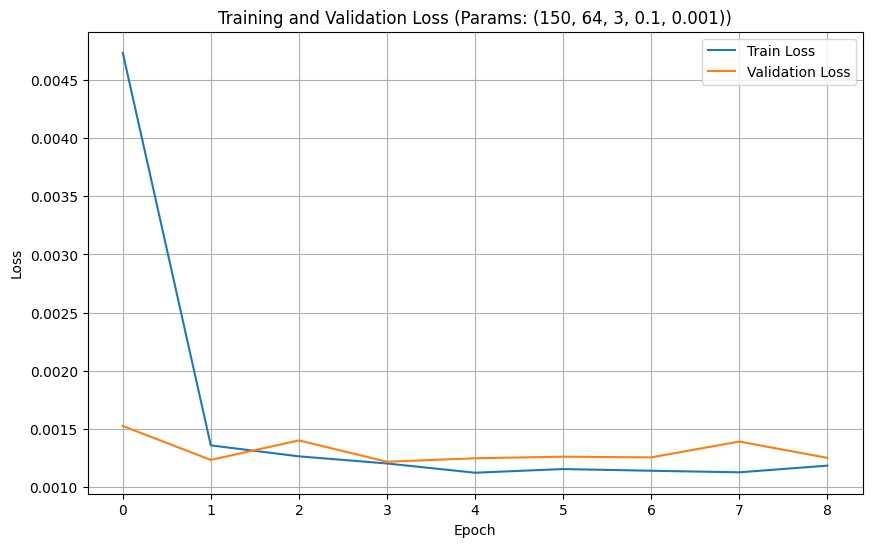

Testowanie kombinacji 46/48: (150, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0059, Val Loss: 0.0014, Duration: 7.57s
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 8.07s
Epoch 3/20, Train Loss: 0.0015, Val Loss: 0.0013, Duration: 9.13s
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 9.48s
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 9.24s
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 10.46s
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 10.98s
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 11.23s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 11.30s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 10.94s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 10.25s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 10.86s
Early stopping triggered at epoch 12


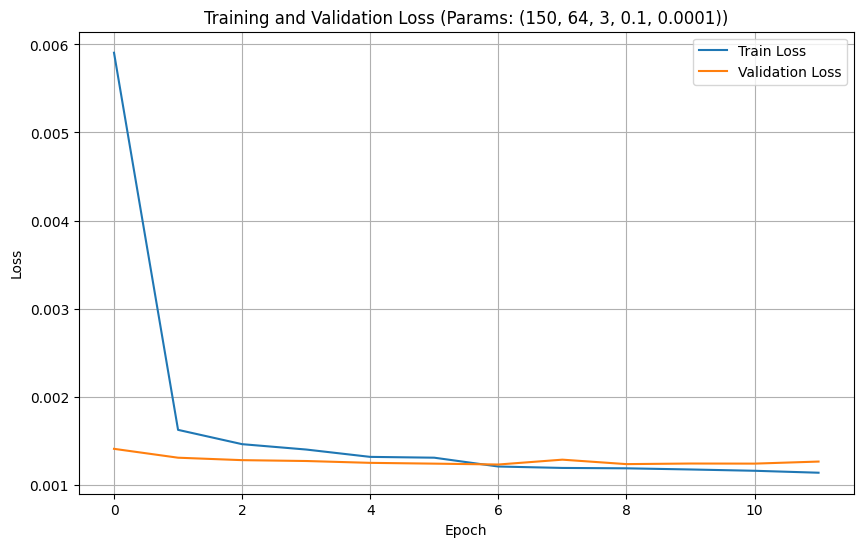

Testowanie kombinacji 47/48: (150, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0053, Val Loss: 0.0012, Duration: 11.50s
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0014, Duration: 12.78s
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 14.49s
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013, Duration: 15.87s
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0015, Duration: 15.63s
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 15.63s
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 16.46s
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 16.52s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 15.63s
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 16.22s
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 15.05s
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 15.30s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 15.31s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 16.42s
Epo

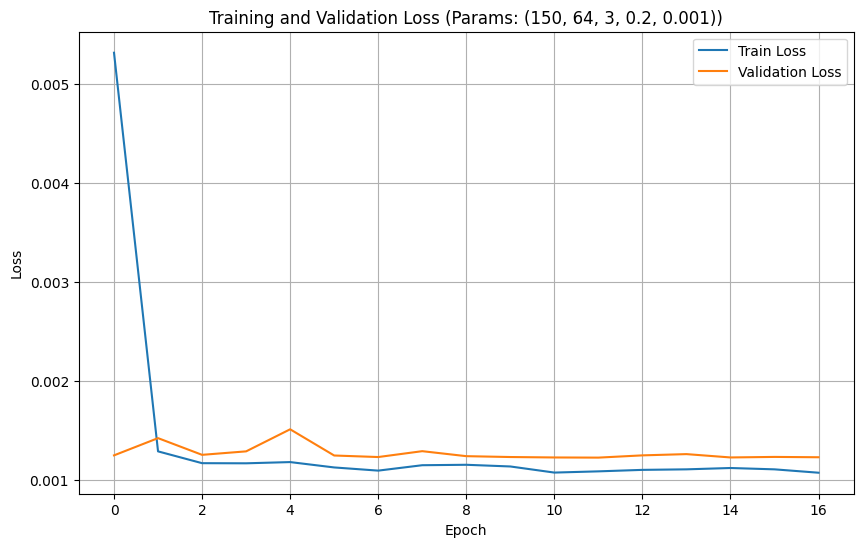

Testowanie kombinacji 48/48: (150, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0077, Val Loss: 0.0016, Duration: 10.72s
Epoch 2/20, Train Loss: 0.0023, Val Loss: 0.0013, Duration: 11.55s
Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0013, Duration: 11.06s
Epoch 4/20, Train Loss: 0.0016, Val Loss: 0.0013, Duration: 10.24s
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0013, Duration: 10.20s
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0012, Duration: 9.77s
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 10.03s
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012, Duration: 9.64s
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 9.53s
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 9.21s
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 8.40s
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012, Duration: 6.64s
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012, Duration: 7.21s
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013, Duration: 6.35s
Early stop

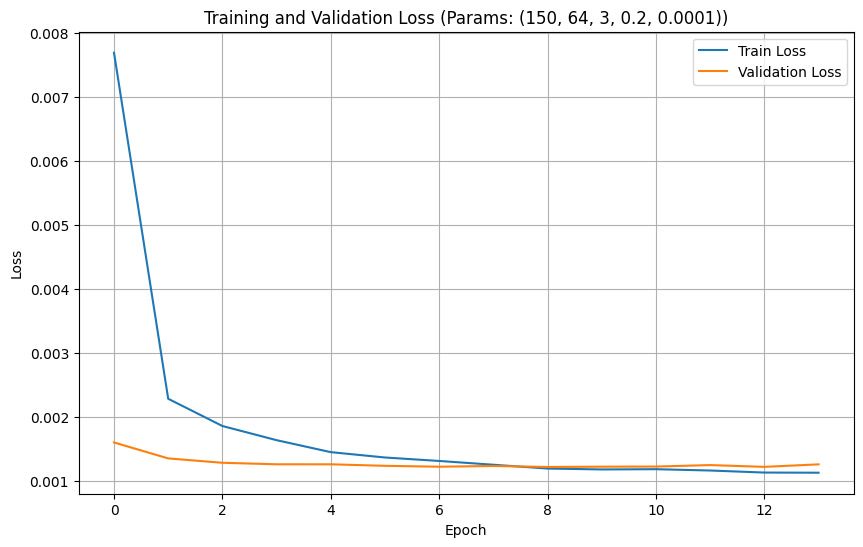

Najlepsze parametry: (100, 32, 3, 0.1, 0.001)
Najlepsza strata walidacyjna: 0.0010
Test Loss for Best Model: 0.0012


In [13]:
import pandas as pd
import time

results = []
best_val_loss = float('inf')
best_model = None
best_params = None
best_test_loader = None

# Iteracja przez kombinacje parametrów
for idx, params in enumerate(param_combinations):
    start_time = time.time()
    print(f"Testowanie kombinacji {idx + 1}/{len(param_combinations)}: {params}")
    trained_model, train_losses, val_losses, val_loss, test_loader = train_and_evaluate(params)
    end_time = time.time()

    # Zapis wyników
    results.append({
        'params': params,
        'train_loss': train_losses[-1],
        'val_loss': val_loss,
        'duration': end_time - start_time
    })

    # Sprawdzenie, czy to najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = trained_model
        best_params = params
        best_test_loader = test_loader

    # Wizualizacja strat dla bieżącego modelu
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Params: {params})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Zapis wyników do pliku
results_df = pd.DataFrame(results)
results_df.to_csv('training_results.csv', index=False)

# Wyświetlenie najlepszych parametrów
print(f"Najlepsze parametry: {best_params}")
print(f"Najlepsza strata walidacyjna: {best_val_loss:.4f}")

# Testowanie najlepszego modelu
best_model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in best_test_loader:
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        test_loss += loss.item()
test_loss /= len(best_test_loader)
print(f"Test Loss for Best Model: {test_loss:.4f}")

In [14]:
from prettytable import PrettyTable

# Tworzenie tabeli wyników
table = PrettyTable(['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Sequence Length', 'Train Loss', 'Val Loss'])
for result in results:
    sequence_length, hidden_size, num_layers, dropout, learning_rate = result['params']
    table.add_row([
        hidden_size,
        num_layers,
        dropout,
        learning_rate,
        sequence_length,  # Użyj konkretnej długości sekwencji
        round(result['train_loss'], 4),  # Ogranicz liczbę miejsc po przecinku
        round(result['val_loss'], 4)     # Ogranicz liczbę miejsc po przecinku
    ])

# Wyświetlenie tabeli wyników
print(table)

# Wyświetlenie najlepszych parametrów
print(f"Najlepszy model: {best_params}, Validation Loss: {best_val_loss:.4f}")

+-------------+------------+---------+---------------+-----------------+------------+----------+
| Hidden Size | Num Layers | Dropout | Learning Rate | Sequence Length | Train Loss | Val Loss |
+-------------+------------+---------+---------------+-----------------+------------+----------+
|      32     |     1      |   0.1   |     0.001     |        30       |   0.001    |  0.0013  |
|      32     |     1      |   0.1   |     0.0001    |        30       |   0.0011   |  0.0012  |
|      32     |     1      |   0.2   |     0.001     |        30       |   0.0011   |  0.0014  |
|      32     |     1      |   0.2   |     0.0001    |        30       |   0.0011   |  0.0012  |
|      32     |     3      |   0.1   |     0.001     |        30       |   0.0012   |  0.0013  |
|      32     |     3      |   0.1   |     0.0001    |        30       |   0.0012   |  0.0012  |
|      32     |     3      |   0.2   |     0.001     |        30       |   0.0011   |  0.0012  |
|      32     |     3      |  

In [16]:
import pandas as pd

# Dane w formacie listy
data = [
    [32, 1, 0.1, 0.001, 0.0010920799170215164, 0.0012714748590951785],
    [32, 1, 0.1, 0.0001, 0.0010931357213731616, 0.001236126758158207],
    [32, 1, 0.2, 0.001, 0.0010580477273100359, 0.0011782949695771094],
    [32, 1, 0.2, 0.0001, 0.0012261315273316277, 0.0012726794848276768],
    [32, 3, 0.1, 0.001, 0.0010840068946802808, 0.0011885049789270852],
    [32, 3, 0.1, 0.0001, 0.0011226383127993153, 0.0011873441544594243],
    [32, 3, 0.2, 0.001, 0.0011502376329454204, 0.0012238063936820254],
    [32, 3, 0.2, 0.0001, 0.001164685656887389, 0.0012288659418118186],
    [64, 1, 0.1, 0.001, 0.0010765972223335638, 0.0012234994610480499],
    [64, 1, 0.1, 0.0001, 0.0010664024544718314, 0.0012119973835069686],
    [64, 1, 0.2, 0.001, 0.0010717538924279412, 0.001191782153910026],
    [64, 1, 0.2, 0.0001, 0.00107421619536434, 0.0011910595567314886],
    [64, 3, 0.1, 0.001, 0.0010618183113101328, 0.0013324381216079928],
    [64, 3, 0.1, 0.0001, 0.001083148418523882, 0.0012162691054982133],
    [64, 3, 0.2, 0.001, 0.0010896638390653197, 0.0012521313910838217],
    [64, 3, 0.2, 0.0001, 0.0011240606747319802, 0.0012475045587052591],
    [32, 1, 0.1, 0.001, 0.0010666740961217632, 0.0010389564725171243],
    [32, 1, 0.1, 0.0001, 0.0011313013441395015, 0.001091205215613757],
    [32, 1, 0.2, 0.001, 0.0010892550732629995, 0.001037651889159211],
    [32, 1, 0.2, 0.0001, 0.0010939602410265554, 0.0010597979874416655],
    [32, 3, 0.1, 0.001, 0.001096635918171766, 0.0011182950152682938],
    [32, 3, 0.1, 0.0001, 0.0011248448708405098, 0.0010374494928068348],
    [32, 3, 0.2, 0.001, 0.0010818616249404537, 0.001071409326479105],
    [32, 3, 0.2, 0.0001, 0.0011593347056380783, 0.001062226011916729],
    [64, 1, 0.1, 0.001, 0.001068310946963417, 0.0010625133249309979],
    [64, 1, 0.1, 0.0001, 0.0011207246114887917, 0.0010625770165851073],
    [64, 1, 0.2, 0.001, 0.0010763561411295086, 0.0010448599350638688],
    [64, 1, 0.2, 0.0001, 0.0010692596920610716, 0.0010697932905584042],
    [64, 3, 0.1, 0.001, 0.001141332631232217, 0.0010863393960919762],
    [64, 3, 0.1, 0.0001, 0.001101050711198089, 0.001039398759270885],
    [64, 3, 0.2, 0.001, 0.0011107806387978295, 0.0010413840895385615],
    [64, 3, 0.2, 0.0001, 0.0011158306306848923, 0.0010467845588989025],
    [32, 1, 0.1, 0.001, 0.0010712636857836818, 0.0012348306481726468],
    [32, 1, 0.1, 0.0001, 0.0011572380133050804, 0.0013152302029387404],
    [32, 1, 0.2, 0.001, 0.0010775292093361108, 0.001248154779508089],
    [32, 1, 0.2, 0.0001, 0.001118434758488244, 0.0012787482895267506],
    [32, 3, 0.1, 0.001, 0.0010940794444953402, 0.0012349218207721908],
    [32, 3, 0.1, 0.0001, 0.0010940379031429378, 0.0012411722758164008],
    [32, 3, 0.2, 0.001, 0.0010819077210423226, 0.0012465152831282467],
    [32, 3, 0.2, 0.0001, 0.0011508843196982828, 0.0012536962555410962],
    [64, 1, 0.1, 0.001, 0.001072724050997446, 0.0012437035814703752],
    [64, 1, 0.1, 0.0001, 0.0010646587683974455, 0.0012516763429933537],
    [64, 1, 0.2, 0.001, 0.001091208194460099, 0.0012366351438686252],
    [64, 1, 0.2, 0.0001, 0.0011032396064062293, 0.0012535967592460413],
    [64, 3, 0.1, 0.001, 0.0011003438965417444, 0.001245311771829923],
    [64, 3, 0.1, 0.0001, 0.0011188942812926446, 0.0012371657940093428],
    [64, 3, 0.2, 0.001, 0.0011100057575580042, 0.0013230419717729092],
    [64, 3, 0.2, 0.0001, 0.0011341372955939732, 0.0012548037339001894]
]

# Nazwy kolumn
columns = ['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Train Loss', 'Val Loss']


# Tworzenie DataFrame
columns = ['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Train Loss', 'Val Loss']
df_results = pd.DataFrame(data, columns=columns)

# Dodawanie kolumny Sequence Lengths
sequence_length_values = np.repeat([30, 100, 150], len(data) // 3)
df_results.insert(4, 'Sequence Lengths', sequence_length_values)

# Wyświetlenie DataFrame z nową kolumną
print(df_results)

    Hidden Size  Num Layers  Dropout  Learning Rate  Sequence Lengths  \
0            32           1      0.1         0.0010                30   
1            32           1      0.1         0.0001                30   
2            32           1      0.2         0.0010                30   
3            32           1      0.2         0.0001                30   
4            32           3      0.1         0.0010                30   
5            32           3      0.1         0.0001                30   
6            32           3      0.2         0.0010                30   
7            32           3      0.2         0.0001                30   
8            64           1      0.1         0.0010                30   
9            64           1      0.1         0.0001                30   
10           64           1      0.2         0.0010                30   
11           64           1      0.2         0.0001                30   
12           64           3      0.1         0.0010

<ipython-input-17-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


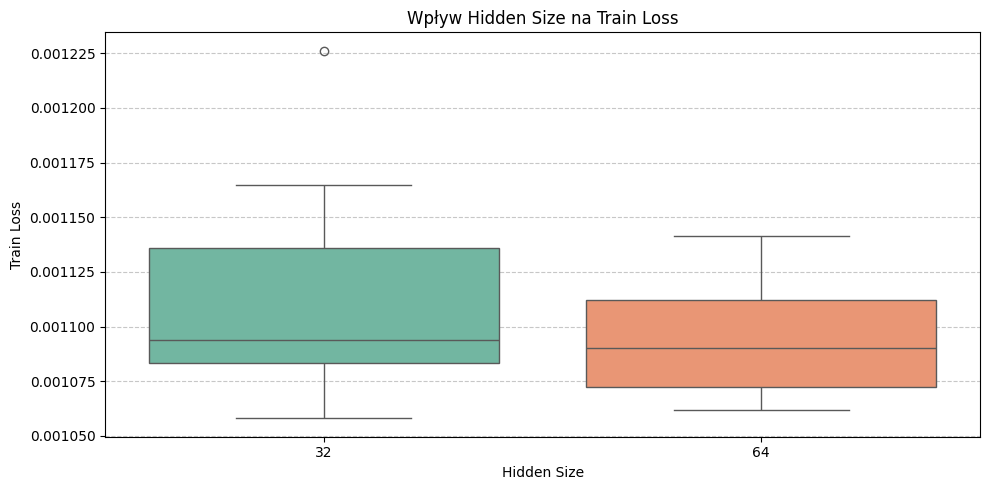

<ipython-input-17-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


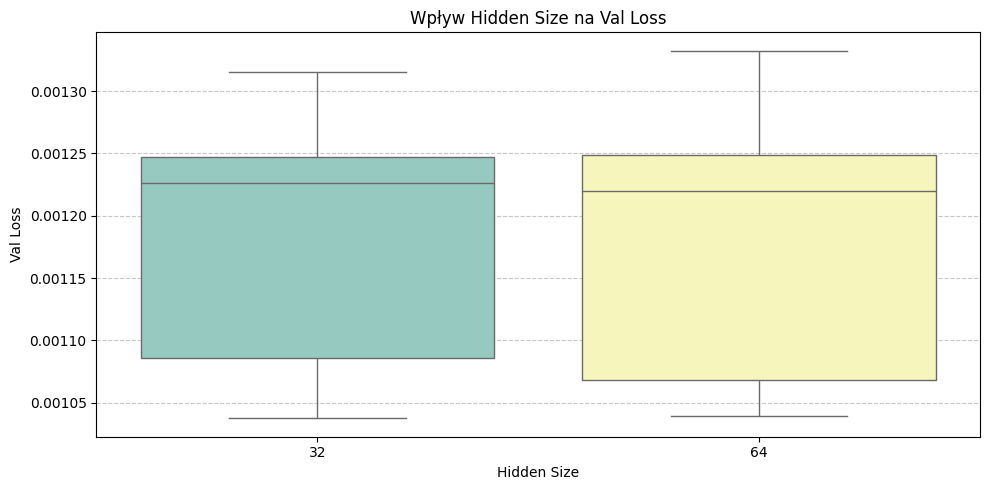

<ipython-input-17-ac84ad7ca49a>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  min_values_summary = pd.concat([min_values_summary, summary], ignore_index=True)
<ipython-input-17-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


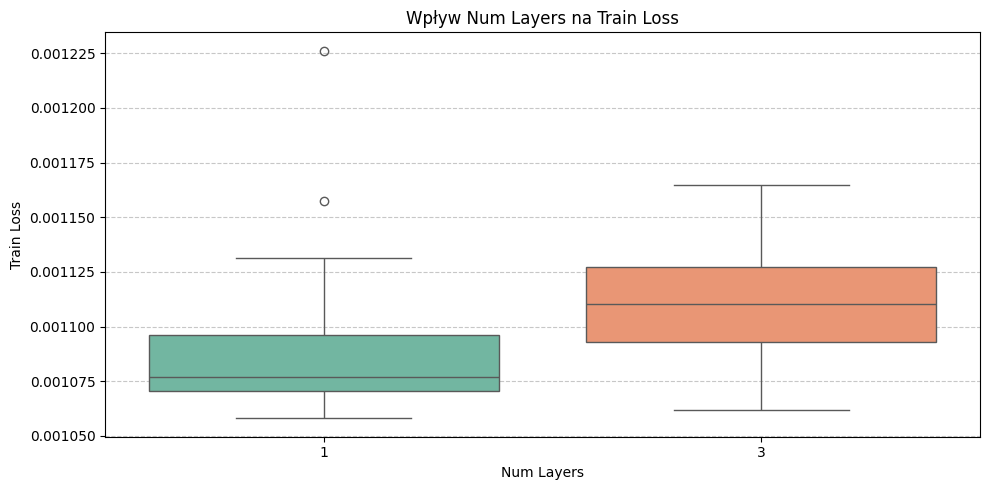

<ipython-input-17-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


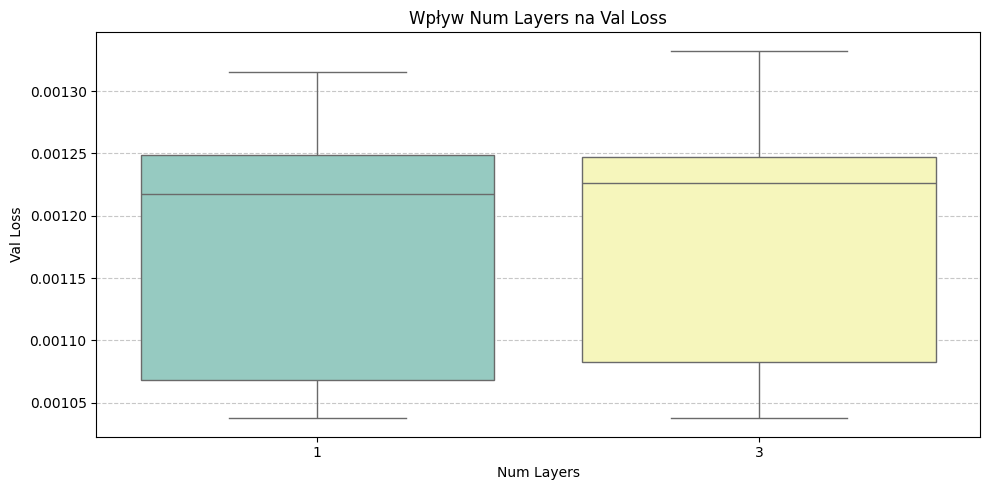

<ipython-input-17-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


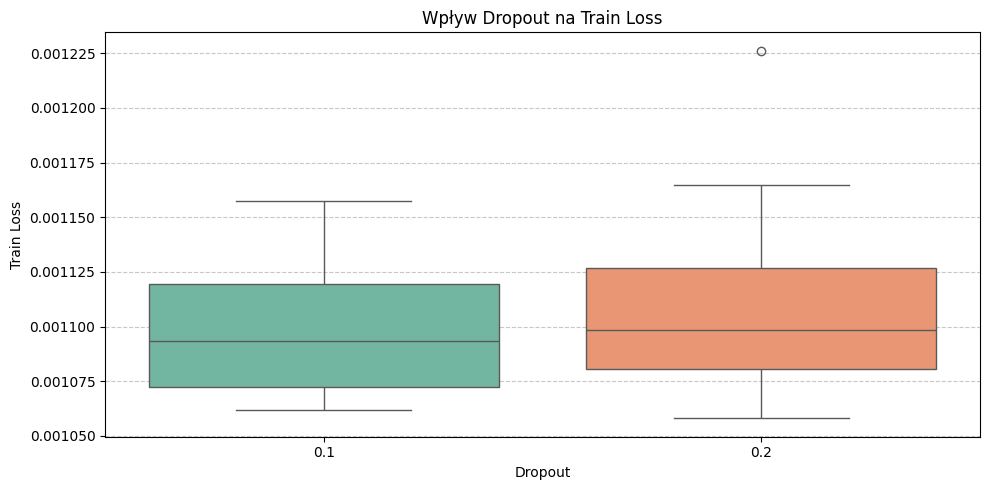

<ipython-input-17-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


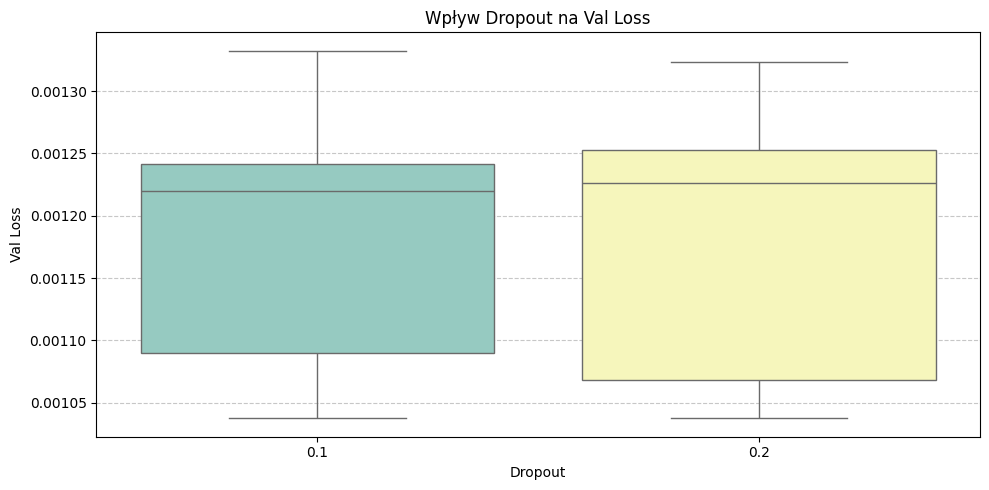

<ipython-input-17-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


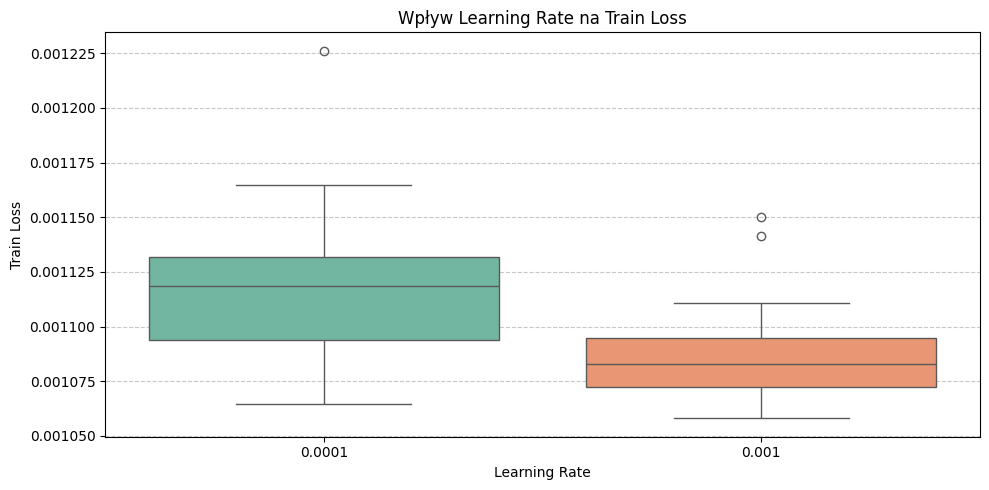

<ipython-input-17-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


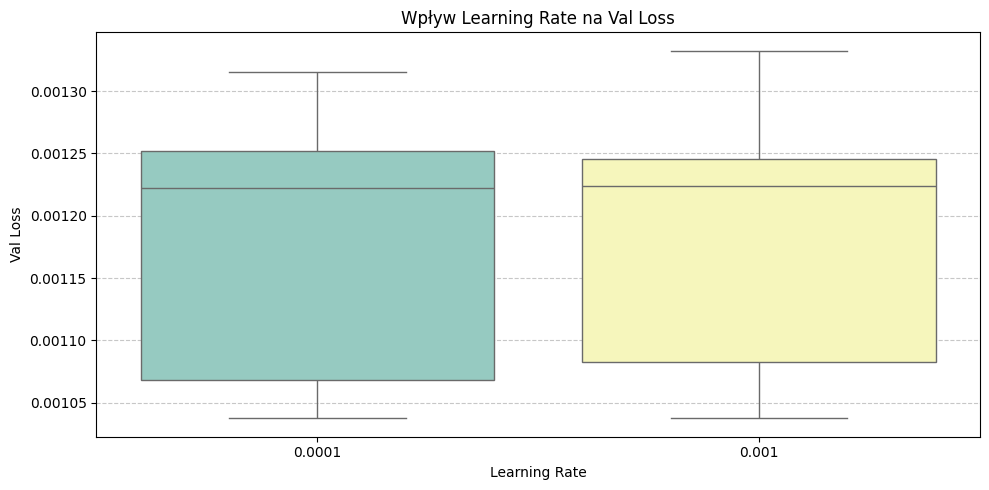

<ipython-input-17-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


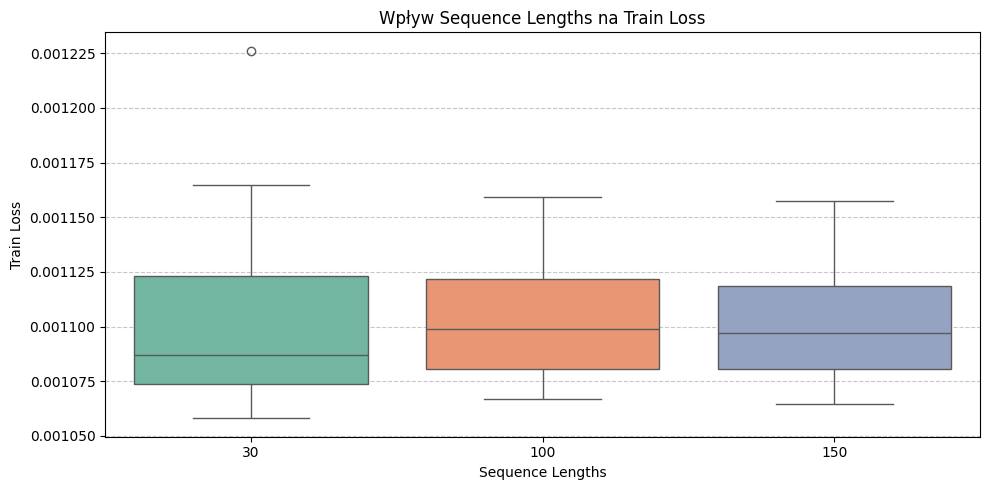

<ipython-input-17-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


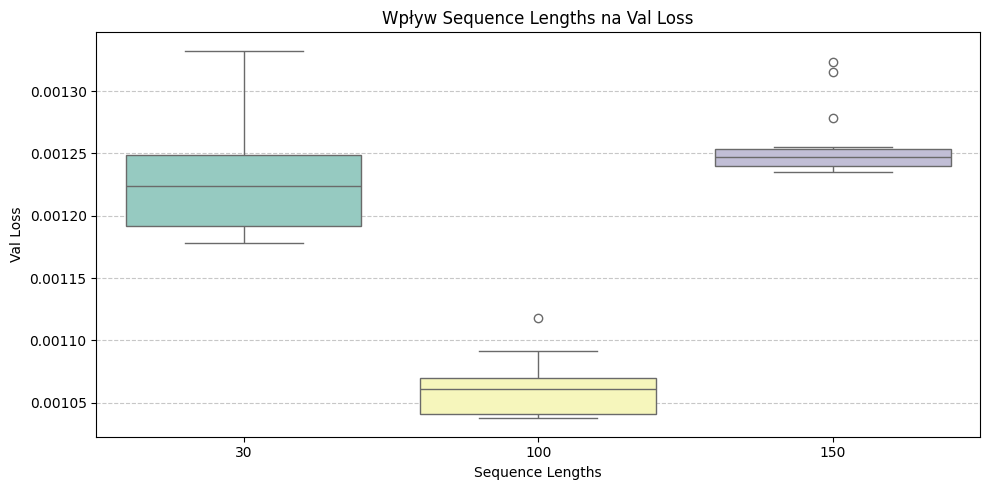

Korelacje między parametrami a wynikami:
                  Train Loss  Val Loss
Val Loss            0.085020  1.000000
Train Loss          1.000000  0.085020
Sequence Lengths    0.002154  0.034038
Num Layers          0.289650  0.025046
Learning Rate      -0.433976  0.006672
Hidden Size        -0.269728  0.002030
Dropout             0.198300 -0.021228

Podsumowanie minimalnych wartości dla każdego parametru:
           Parameter   Value  Min Train Loss  Min Val Loss
0        Hidden Size      32        0.001058      0.001037
1        Hidden Size      64        0.001062      0.001039
2         Num Layers       1        0.001058      0.001038
3         Num Layers       3        0.001062      0.001037
4            Dropout     0.1        0.001062      0.001037
5            Dropout     0.2        0.001058      0.001038
6      Learning Rate  0.0001        0.001065      0.001037
7      Learning Rate   0.001        0.001058      0.001038
8   Sequence Lengths      30        0.001058      0.001178

,Parameter,Value,Min Train Loss,Min Val Loss
0,Hidden Size,32,0.001058,0.001037
1,Hidden Size,64,0.001062,0.001039
2,Num Layers,1,0.001058,0.001038
3,Num Layers,3,0.001062,0.001037
4,Dropout,0.1,0.001062,0.001037
5,Dropout,0.2,0.001058,0.001038
6,Learning Rate,0.0001,0.001065,0.001037
7,Learning Rate,0.001,0.001058,0.001038
8,Sequence Lengths,30,0.001058,0.001178
9,Sequence Lengths,100,0.001067,0.001037


In [17]:
def analyze_results(df_results):
    # Lista parametrów do analizy
    parameters = ['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Sequence Lengths']

    # DataFrame do przechowywania minimalnych wartości
    min_values_summary = pd.DataFrame(columns=['Parameter', 'Value', 'Min Train Loss', 'Min Val Loss'])

    for param in parameters:
        # Wykres wpływu parametru na Train Loss
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')
        plt.title(f'Wpływ {param} na Train Loss')
        plt.xlabel(param)
        plt.ylabel('Train Loss')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Wykres wpływu parametru na Val Loss
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')
        plt.title(f'Wpływ {param} na Val Loss')
        plt.xlabel(param)
        plt.ylabel('Val Loss')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Minimalne wartości dla Train Loss i Val Loss
        min_train_loss = df_results.groupby(param)['Train Loss'].min()
        min_val_loss = df_results.groupby(param)['Val Loss'].min()

        # Dodanie do tabeli podsumowania
        summary = pd.DataFrame({
            'Parameter': param,
            'Value': min_train_loss.index,
            'Min Train Loss': min_train_loss.values,
            'Min Val Loss': min_val_loss.values
        })

        # Dodanie danych do tabeli podsumowania za pomocą pd.concat
        min_values_summary = pd.concat([min_values_summary, summary], ignore_index=True)

    # Korelacje między parametrami a wynikami
    correlation = df_results.corr()
    print("Korelacje między parametrami a wynikami:")
    print(correlation[['Train Loss', 'Val Loss']].sort_values(by='Val Loss', ascending=False))

    # Wyświetlenie tabeli minimalnych wartości
    print("\nPodsumowanie minimalnych wartości dla każdego parametru:")
    print(min_values_summary)
    return min_values_summary

# Uruchomienie analizy
analyze_results(df_results)

In [18]:
for result in results:
    print(result['params'])

(30, 32, 1, 0.1, 0.001)
(30, 32, 1, 0.1, 0.0001)
(30, 32, 1, 0.2, 0.001)
(30, 32, 1, 0.2, 0.0001)
(30, 32, 3, 0.1, 0.001)
(30, 32, 3, 0.1, 0.0001)
(30, 32, 3, 0.2, 0.001)
(30, 32, 3, 0.2, 0.0001)
(30, 64, 1, 0.1, 0.001)
(30, 64, 1, 0.1, 0.0001)
(30, 64, 1, 0.2, 0.001)
(30, 64, 1, 0.2, 0.0001)
(30, 64, 3, 0.1, 0.001)
(30, 64, 3, 0.1, 0.0001)
(30, 64, 3, 0.2, 0.001)
(30, 64, 3, 0.2, 0.0001)
(100, 32, 1, 0.1, 0.001)
(100, 32, 1, 0.1, 0.0001)
(100, 32, 1, 0.2, 0.001)
(100, 32, 1, 0.2, 0.0001)
(100, 32, 3, 0.1, 0.001)
(100, 32, 3, 0.1, 0.0001)
(100, 32, 3, 0.2, 0.001)
(100, 32, 3, 0.2, 0.0001)
(100, 64, 1, 0.1, 0.001)
(100, 64, 1, 0.1, 0.0001)
(100, 64, 1, 0.2, 0.001)
(100, 64, 1, 0.2, 0.0001)
(100, 64, 3, 0.1, 0.001)
(100, 64, 3, 0.1, 0.0001)
(100, 64, 3, 0.2, 0.001)
(100, 64, 3, 0.2, 0.0001)
(150, 32, 1, 0.1, 0.001)
(150, 32, 1, 0.1, 0.0001)
(150, 32, 1, 0.2, 0.001)
(150, 32, 1, 0.2, 0.0001)
(150, 32, 3, 0.1, 0.001)
(150, 32, 3, 0.1, 0.0001)
(150, 32, 3, 0.2, 0.001)
(150, 32, 3, 0.2, 0.00

Ewaluacja najlepszego modelu na danych testowych (Parametry: (100, 32, 3, 0.1, 0.001)):


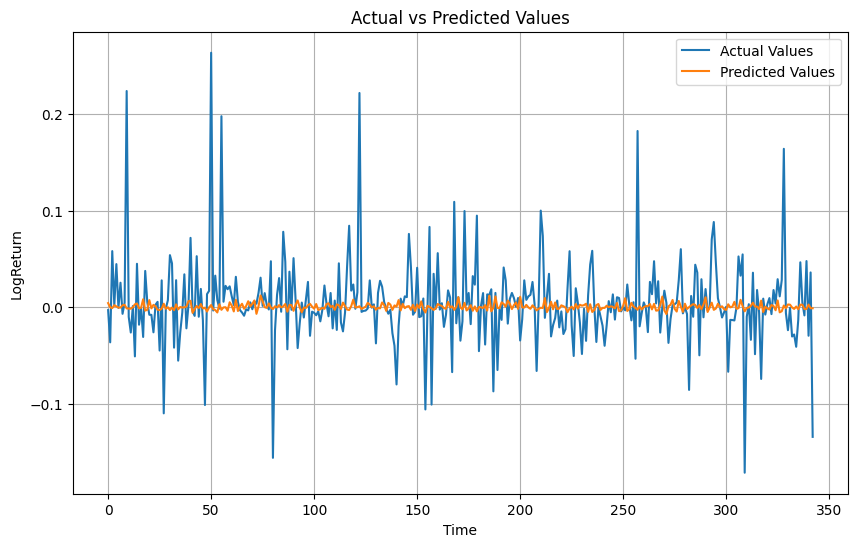

Mean Absolute Error (MAE): 0.0274
Mean Squared Error (MSE): 0.0020
Root Mean Squared Error (RMSE): 0.0449
R² Score: -0.0157


In [19]:
# Funkcja ewaluacji i wizualizacji
def evaluate_and_visualize(model, test_loader, criterion):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Odskalowanie wartości
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)

    # Wizualizacja wyników
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values')
    plt.plot(predictions, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('LogReturn')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wyliczenie metryk
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return predictions, actuals

print(f"Ewaluacja najlepszego modelu na danych testowych (Parametry: {best_params}):")
predictions, actuals = evaluate_and_visualize(best_model, test_loader, criterion)